In [1]:
!pip install --upgrade torch --user

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0 requires torch==1.11.0, but you have torch 1.12.1 which is incompatible.
torchaudio 0.10.0 requires torch==1.10.0, but you have torch 1.12.1 which is incompatible.


In [2]:
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
import glob
import pandas as pd
import numpy as np
import os
import math
from pandas import json_normalize
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from matplotlib.animation import FuncAnimation
import pickle
from statsbombpy import sb
from datetime import datetime, timedelta
from tqdm import tqdm
import itertools
import seaborn as sns



1.12.1+cpu


In [ ]:
# !pip uninstall torch-scatter
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cpu.html
# !pip uninstall torch-sparse
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cpu.html
# !pip install torch-geometric

In [4]:
import os.path as osp
from torch_geometric.data import Data, Dataset, download_url
from torch_geometric.loader import DataLoader


# Graph data preprocessing

## input files: master_data_training.json, tracking_data.json, train_index.pkl, test_index.pkl

### Graph elements:

To create a graph, there needs to be:
- Nodes - in this instance each node is a player on the field. Each node feature will be the player's location (x&y), flag ball carrier and flag goalkeeper
- Edges - denotes relationships between each pair of players. Edge features will be flag teammate, distance and angle between each pair of players
- Labels - each graph has its own label - binary_pass_risk and binary_pass_reward.

#### First step: create a Dataset class that takes json master data and tracking data files as input and output graphs 
- The main method used is "process", which processes player tracking data into node features, create the adjacency matrix, create edge feature, and the labels from the master data file.

In [5]:

class tracking_Dataset(Dataset):
    def __init__(self, root, raw_files, event_file, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.raw_files = raw_files
        self.event_file = open(event_file, 'r')
        
        super(tracking_Dataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.raw_files

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.event_df = pd.read_json(self.event_file)
        self.event_lst = self.event_df.index
        return [f'data_{i}.pt' for i in self.event_lst]

    def download(self):
        pass

    def process(self):
        #loop through each json file in raw_paths 
        for raw_path in self.raw_paths:
            #get tracking dataframe for each match (only get events in master_data)
            self.data = self._frames(raw_path)
            #loop through each match event to create a graph
            for index, event in enumerate(tqdm(self.event_lst, total=len(self.event_lst))):
                
                df = self.data.loc[self.data['id']==event].reset_index()
                
                # Get node features
                node_feats = self._get_node_attr(df)
                # Get adjacency info
                edge_index = self._get_adjacency_info(df)
                # Get edge features
                edge_feats = self._get_edge_attr(df, edge_index)
                # Get labels info
#                 label = self._get_label(self.event_df, event)
                label_risk = self._get_label_risk(self.event_df, event)
                label_reward = self._get_label_reward(self.event_df, event)
                # Get universal features
#                 uni_feats = self._get_universal_attr(self.event_df, event)

                # Create data object
                data = Data(x=node_feats, 
                            edge_index=edge_index,
                            edge_attr=edge_feats,
                            y_risk=label_risk,
                            y_reward=label_reward,
                            event=event
                            ) 
                if self.test:
                    torch.save(data, 
                        os.path.join(self.processed_dir, 
                                     f'data_test_{index}.pt'))
                else:
                    torch.save(data, 
                        os.path.join(self.processed_dir, 
                                     f'data_{index}.pt'))


    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))        
        return data
    
    def _frames(self, path):
        with open(path, 'r', encoding='utf-8') as tracking_file:
            frames = pd.read_json(tracking_file)
            frames = frames.loc[frames['id'].isin(self.event_lst)]
        return frames

    def _get_node_attr(self, df):
        
        
        df['loc_x']=df.apply(lambda x: self._get_1d_coor(x['location'], 'x'), axis=1)
        df['loc_y']=df.apply(lambda x: self._get_1d_coor(x['location'], 'y'), axis=1)
        df = df.drop(['id', 'actor', 'location', 'visible_area', 'match_id', 'type', 
                 'pass_length', 'location_pass','pass_end_location', 
                 'pass_degree', 'passer_degree_to_goal', 'br_degree_to_goal', 
                 'actor_location', 'dist_actor_from_goal', 'dist_br_from_goal'], axis=1)
        df = df.astype({'keeper':int})
        df = np.vstack(df.values).astype(np.float)
        return torch.from_numpy(df)

    def _get_adjacency_info(self, df):
        players = df.index.to_list()
        permutations = list(itertools.combinations(players, 2))
        edges_source = [e[0] for e in permutations]
        edges_target = [e[1] for e in permutations]
        adjacency_info = np.column_stack([edges_source, edges_target])
        adjacency_info = torch.tensor(adjacency_info.T)
        return adjacency_info
    
    def _get_edge_attr(self, df, edge_index):
        edge_index = np.array(edge_index.t())
        # maxmimum distance between 2 players are the length between 2 diagonal corner flag
        max_dist_pitch = math.sqrt(80**2+120**2)
        dist = [self._get_dist(df.at[edge[0],'location'], df.at[edge[1],'location']) for edge in edge_index]
        edge_features = torch.FloatTensor([(max_dist_pitch-x)/max_dist_pitch for x in dist])
        return edge_features
    
    def _get_label_reward(self, event_df, event):
        label = event_df.loc[event, 'binary_pass_reward']
        return torch.tensor(label, dtype=torch.int64)
    
    def _get_label_risk(self, event_df, event):
        label = event_df.loc[event, 'binary_pass_risk']
        return torch.tensor(label, dtype=torch.int64)
    
    def _get_dist(self, start, end):
        start, end = np.array(start), np.array(end)
        return np.linalg.norm(start-end)
    
    def _get_angle(self, start_location, end_location):
        if isinstance(start_location, list)&isinstance(end_location, list):
            y= end_location[1]-start_location[1]
            x= end_location[0]-start_location[0]
            angles = np.degrees(np.arctan2(y, x))
            angles = abs(angles) if abs(angles)<180 else 360-abs(angles)
        return angles
    
    def _get_1d_coor(self, coor, dim):
        dim_dict = {'x':0, 'y':1}
        try:
            dim=dim_dict[dim]
            if isinstance(coor,list):
                return coor[dim]
            else:
                return np.NaN
        except:
            return np.NaN

#### Here the root directory which should contain a "raw" folder with the json file and a "processed" folder where the graphs will be saved to

In [7]:
root = "pyg_data"

event_file = root+"/raw/master_data_tabular/master_data_training.json"

tracking_file = root+"/raw/tracking_data.json"

Calling the dataset class we just created to generate the graphs

In [304]:
tracking_dataset = tracking_Dataset(root, tracking_file)

### Step 2: feed train and test set into 2 dataloaders
- First we import the training and testing index split by sklearn for the logistic regression model and 

In [11]:
with open('train_index.pkl', 'rb') as f:
    train_index = pickle.load(f)
with open('test_index.pkl', 'rb') as f:
    test_index = pickle.load(f)   

Put all train and test graphs in 2 separate list and feed into dataloader (because of a bug, the tracking dataset variable doesn't hold all generated graphs) 

In [299]:
def get_data(i):
    data = torch.load(os.path.join(f"C:/Users/Huy's/Desktop/pyg_data/processed/data_{i}.pt")) 
    return data

train_data_lst = [get_data(i) for i in train_index]
test_data_lst = [get_data(i) for i in test_index]

train_data_lst[0]

Data(x=[12, 15], edge_index=[2, 66], edge_attr=[66], y_risk=1, y_reward=0, event='5667a549-c8a6-488e-b2ff-cedce009202d')

In [305]:
train_loader = DataLoader(train_data_lst, batch_size=16, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data_lst, batch_size=64)
                                                                                                                                                                                            

## Specify model and training

### Model:
- We implement a simple Graph Neural Network with 2 layers of Graph Convolutional network, activated with tanH activation function. Then we apply a global mean pool layer to collapse all node embeddings into an aggregated graph embedding. This graph embedding is then applied with a softmax function so the features won't explode, and then we run a linear layer for the final output. The weights of the final linear layer was initialised with Xavier Initialization
- We use Pytorch's Binary Cross Entropy Loss function with logits (same as log_loss in sklearn for easy comparison) and Adam with learning rate of 0.002 (risk) and 0.0001 (reward) as the optimizer.

In [454]:
from torch import nn
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU, Softmax, Sigmoid, Tanh
import torch.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

#use GPU to train
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class GCN(torch.nn.Module):
    def __init__(self, first_hidden_channels, second_hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(14, first_hidden_channels)
        self.conv2 = GCNConv(first_hidden_channels, second_hidden_channels)
        self.lin = Linear(second_hidden_channels, 1)
#         self.relu = ReLU()
        self.tanh = Tanh()
#         self.sigmoid = Sigmoid()
        self.softmax = Softmax(dim=1)

    def forward(self, x, edge_index, edge_weight, batch):
        # 1. Obtain node embeddings 
        x = x[:,1:] #((x - mean)/std)
        x = self.conv1(x, edge_index, edge_weight)
        x = self.tanh(x)
        x = self.conv2(x, edge_index, edge_weight)
#         x = self.sigmoid(x)
#         x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = gap(x, batch)  # [batch_size, hidden_channels]
        x = self.softmax(x)
        # 3. Apply a final classifier
        out = self.lin(x)
        return out

model_risk = GCN(first_hidden_channels=32, second_hidden_channels=20)
model_reward = GCN(first_hidden_channels=32, second_hidden_channels=20)
    

In [455]:
def init_weights(m):
  """Uses Xavier Initialization for all Linear layers in the model
  """
  if isinstance(m, Linear): 
    nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.01)

model_risk.apply(init_weights)

def init_weights(m):
  """Uses Xavier Initialization for all Linear layers in the model
  """
  if isinstance(m, Linear): 
    nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.09)
model_reward.apply(init_weights)

GCN(
  (conv1): GCNConv(14, 32)
  (conv2): GCNConv(32, 20)
  (lin): Linear(in_features=20, out_features=1, bias=True)
  (tanh): Tanh()
  (softmax): Softmax(dim=1)
)

### Training and testing function:
- For each epoch we generate predictions, confusion matrix, f1_score, accuracy score, precision, recall and auc scores, and save the loss of both train and test

In [381]:
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score, roc_auc_score

In [453]:

def train_one_epoch(epoch, model, train_loader, optimizer, loss_fn, label='risk'):
#     if label == "risk":
#         y=batch.y_risk
#     else:
#         y=batch.y_reward
    # Enumerate over the data
    all_preds = []
    all_labels = []
    running_loss = 0.0
    step = 0
    for _, batch in enumerate(tqdm(train_loader)):
        if label == "risk":
            y=batch.y_risk
        else:
            y=batch.y_reward
        # Use GPU
        batch.to(device)  
        # Reset gradients
        optimizer.zero_grad() 
        # Passing the node features and the connection info
        pred = model(batch.x.float(), 
                     batch.edge_index.type(torch.int64) ,
                     batch.edge_attr, 
                     batch.batch) 
        
        # Calculating the loss and gradients
        loss = loss_fn(torch.squeeze(pred), y.float())
        loss.backward()  
        optimizer.step()  
        # Update tracking
        running_loss += loss.item()
        step += 1
        all_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
        all_labels.append(y.cpu().detach().numpy())
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "train")
    return running_loss/step

def test(epoch, model, test_loader, loss_fn, label='risk'):
    all_preds = []
    all_preds_raw = []
    all_labels = []
    running_loss = 0.0
    step = 0
    for batch in test_loader:
        if label == "risk":
            y=batch.y_risk
        else:
            y=batch.y_reward
        batch.to(device)  
        pred = model(batch.x.float(), 
                     batch.edge_index.type(torch.int64) ,
                     batch.edge_attr, 
                     batch.batch) 
        loss = loss_fn(torch.squeeze(pred), y.float())

         # Update tracking
        running_loss += loss.item()
        step += 1
        all_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
        all_preds_raw.append(torch.sigmoid(pred).cpu().detach().numpy())
        all_labels.append(y.cpu().detach().numpy())
    
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    print(all_preds_raw[0][:10])
    print(all_preds[:10])
    print(all_labels[:10])
    calculate_metrics(all_preds, all_labels, epoch, "test")
    return running_loss/step



def calculate_metrics(y_pred, y_true, epoch, type):
    print(f"\n Confusion matrix: \n {confusion_matrix(y_pred, y_true)}")
    print(f"F1 Score: {f1_score(y_true, y_pred)}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    print(f"Precision: {prec}")
    print(f"Recall: {rec}")

    try:
        roc = roc_auc_score(y_true, y_pred)
        print(f"ROC AUC: {roc}")
    except:
        print(f"ROC AUC: notdefined")


### Run training
- We run 100 epochs for both risk and reward models

#### Risk model

In [442]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_risk.parameters(), lr=0.0015)

In [443]:
train_risk_loss = {}
test_risk_loss = {}
for epoch in range(100): 

    model_risk.train()
    loss = train_one_epoch(epoch, model_risk, train_loader, optimizer, loss_fn)
    print(f"Epoch {epoch} | Train Loss {loss}")
    train_risk_loss[epoch] = loss


    # Testing
    model_risk.eval()
    t_loss = test(epoch, model_risk, test_loader, loss_fn)
    print(f"Epoch {epoch} | Test Loss {t_loss}")
    test_risk_loss[epoch] = t_loss

100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 201.37it/s]



 Confusion matrix: 
 [[  105   147]
 [ 5211 27657]]
F1 Score: 0.9116890822784811
Accuracy: 0.8382246376811594
Precision: 0.8414567360350493
Recall: 0.9947129909365559
ROC AUC: 0.5072323419694066
Epoch 0 | Train Loss 0.3898019288905001


  1%|▊                                                                              | 22/2070 [00:00<00:09, 213.55it/s]

[[0.6169063 ]
 [0.54942006]
 [0.5608791 ]
 [0.92351216]
 [0.91004694]
 [0.91170007]
 [0.9468801 ]
 [0.66060853]
 [0.9037067 ]
 [0.5079565 ]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[   38    35]
 [ 2312 11814]]
F1 Score: 0.9096438883541867
Accuracy: 0.8347066694837665
Precision: 0.8363301713153051
Recall: 0.9970461642332686
ROC AUC: 0.506608188499613
Epoch 0 | Test Loss 0.34127464460897017


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 201.32it/s]



 Confusion matrix: 
 [[ 1242   748]
 [ 4078 27052]]
F1 Score: 0.9181062277278127
Accuracy: 0.8542874396135266
Precision: 0.8690009637006103
Recall: 0.9730935251798561
ROC AUC: 0.6032760858981987
Epoch 1 | Train Loss 0.3296320251652584


  1%|▉                                                                              | 23/2070 [00:00<00:09, 221.10it/s]

[[0.64138305]
 [0.48191667]
 [0.58631223]
 [0.7582749 ]
 [0.8489832 ]
 [0.9034672 ]
 [0.963796  ]
 [0.5962397 ]
 [0.8528697 ]
 [0.5825252 ]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  671   366]
 [ 1679 11483]]
F1 Score: 0.9182359761704851
Accuracy: 0.8559757729417564
Precision: 0.8724358000303906
Recall: 0.969111317410752
ROC AUC: 0.6273216161521845
Epoch 1 | Test Loss 0.32666726417101183


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 198.71it/s]



 Confusion matrix: 
 [[ 1918  1252]
 [ 3402 26548]]
F1 Score: 0.9194112554112555
Accuracy: 0.8594806763285024
Precision: 0.8864106844741235
Recall: 0.9549640287769784
ROC AUC: 0.6577451722832262
Epoch 2 | Train Loss 0.3228129346895477


  1%|▊                                                                              | 20/2070 [00:00<00:10, 196.06it/s]

[[0.65700626]
 [0.4733518 ]
 [0.5513659 ]
 [0.91433305]
 [0.9183346 ]
 [0.9291322 ]
 [0.97105217]
 [0.4778204 ]
 [0.83319116]
 [0.5586704 ]]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  786   464]
 [ 1564 11385]]
F1 Score: 0.9182192112267119
Accuracy: 0.8571730403549546
Precision: 0.8792184724689165
Recall: 0.9608405772639041
ROC AUC: 0.6476543311851435
Epoch 2 | Test Loss 0.32137968371043335


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 203.64it/s]



 Confusion matrix: 
 [[ 1899  1197]
 [ 3420 26604]]
F1 Score: 0.9201556420233463
Accuracy: 0.8605978260869566
Precision: 0.8860911270983214
Recall: 0.9569439948203302
ROC AUC: 0.6569829957181177
Epoch 3 | Train Loss 0.3179188975947347


  1%|▊                                                                              | 20/2070 [00:00<00:10, 192.23it/s]

[[0.68480927]
 [0.44460782]
 [0.81876254]
 [0.7539256 ]
 [0.86946976]
 [0.8790372 ]
 [0.9748345 ]
 [0.56811184]
 [0.8842135 ]
 [0.39976078]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1057   662]
 [ 1293 11187]]
F1 Score: 0.919643224135805
Accuracy: 0.8623142474822171
Precision: 0.8963942307692307
Recall: 0.9441303063549666
ROC AUC: 0.6969587701987598
Epoch 3 | Test Loss 0.32017456471651523


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 206.15it/s]



 Confusion matrix: 
 [[ 1973  1228]
 [ 3345 26574]]
F1 Score: 0.920774068363334
Accuracy: 0.8619263285024155
Precision: 0.8881981349644039
Recall: 0.9558305157902309
ROC AUC: 0.6634173263419
Epoch 4 | Train Loss 0.317430502127694


  1%|▋                                                                              | 19/2070 [00:00<00:11, 184.40it/s]

[[0.7186142 ]
 [0.40044338]
 [0.52318287]
 [0.82582635]
 [0.94126135]
 [0.8861598 ]
 [0.96757495]
 [0.6091814 ]
 [0.78687674]
 [0.51924855]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  796   496]
 [ 1554 11353]]
F1 Score: 0.917191791888835
Accuracy: 0.8556236354672865
Precision: 0.8796002169365461
Recall: 0.9581399274200354
ROC AUC: 0.6484316658376773
Epoch 4 | Test Loss 0.3202527683597427


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 187.83it/s]



 Confusion matrix: 
 [[ 2051  1289]
 [ 3266 26514]]
F1 Score: 0.9208967924561069
Accuracy: 0.862469806763285
Precision: 0.890329079919409
Recall: 0.9536380966082797
ROC AUC: 0.6696909685599233
Epoch 5 | Train Loss 0.3133117157461994


  1%|▊                                                                              | 20/2070 [00:00<00:10, 194.13it/s]

[[0.7098904 ]
 [0.48415333]
 [0.5439865 ]
 [0.89386946]
 [0.94600993]
 [0.8834487 ]
 [0.9821482 ]
 [0.8546287 ]
 [0.8593789 ]
 [0.5482099 ]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  727   342]
 [ 1623 11507]]
F1 Score: 0.9213339204932143
Accuracy: 0.861609972533277
Precision: 0.8763899466869763
Recall: 0.9711368047936535
ROC AUC: 0.6402492534606565
Epoch 5 | Test Loss 0.3203230200855582


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 195.58it/s]



 Confusion matrix: 
 [[ 2084  1262]
 [ 3236 26538]]
F1 Score: 0.9218744572202731
Accuracy: 0.8641908212560386
Precision: 0.89131456975885
Recall: 0.9546043165467626
ROC AUC: 0.6731668199275167
Epoch 6 | Train Loss 0.3096164327546738


  1%|▋                                                                              | 19/2070 [00:00<00:11, 186.23it/s]

[[0.626924  ]
 [0.39063695]
 [0.57463175]
 [0.7941705 ]
 [0.8840646 ]
 [0.86057746]
 [0.9756495 ]
 [0.45334902]
 [0.79221547]
 [0.6168738 ]]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  953   600]
 [ 1397 11249]]
F1 Score: 0.9184731577873035
Accuracy: 0.8593562926966688
Precision: 0.8895302862565238
Recall: 0.9493628154274623
ROC AUC: 0.6774473651605397
Epoch 6 | Test Loss 0.3113180729182991


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 201.21it/s]



 Confusion matrix: 
 [[ 2115  1293]
 [ 3205 26507]]
F1 Score: 0.9217902350813743
Accuracy: 0.8641908212560386
Precision: 0.8921311254711901
Recall: 0.9534892086330935
ROC AUC: 0.6755227998052686
Epoch 7 | Train Loss 0.3090629283302792


  1%|▊                                                                              | 21/2070 [00:00<00:09, 205.84it/s]

[[0.6617347 ]
 [0.4178298 ]
 [0.7069145 ]
 [0.8046858 ]
 [0.91647327]
 [0.9085842 ]
 [0.97681355]
 [0.58551365]
 [0.7512153 ]
 [0.57170445]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1054   680]
 [ 1296 11169]]
F1 Score: 0.9187299498231472
Accuracy: 0.8608352700894429
Precision: 0.896028880866426
Recall: 0.9426111908177905
ROC AUC: 0.6955609145578314
Epoch 7 | Test Loss 0.3108627184688508


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 191.70it/s]



 Confusion matrix: 
 [[ 2071  1237]
 [ 3250 26562]]
F1 Score: 0.9221155682074604
Accuracy: 0.8645229468599034
Precision: 0.890983496578559
Recall: 0.9555019964746934
ROC AUC: 0.6723572752529452
Epoch 8 | Train Loss 0.3069140252373789


  1%|▋                                                                              | 19/2070 [00:00<00:11, 180.91it/s]

[[0.5008438 ]
 [0.37920642]
 [0.57267153]
 [0.7995471 ]
 [0.873417  ]
 [0.9457944 ]
 [0.9757116 ]
 [0.5086775 ]
 [0.742636  ]
 [0.6332344 ]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1016   602]
 [ 1334 11247]]
F1 Score: 0.9207531723291036
Accuracy: 0.8636523698852032
Precision: 0.8939670932358318
Recall: 0.9491940248122205
ROC AUC: 0.6907672251720677
Epoch 8 | Test Loss 0.3122369349002838


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 185.58it/s]



 Confusion matrix: 
 [[ 2193  1317]
 [ 3127 26483]]
F1 Score: 0.9225918829472217
Accuracy: 0.8658212560386473
Precision: 0.8943937858831476
Recall: 0.9526258992805755
ROC AUC: 0.6824219721966787
Epoch 9 | Train Loss 0.30747972976434346


  1%|▋                                                                              | 19/2070 [00:00<00:10, 189.96it/s]

[[0.43706045]
 [0.44805813]
 [0.6502951 ]
 [0.81117624]
 [0.82003903]
 [0.7732749 ]
 [0.9868967 ]
 [0.62464356]
 [0.7098554 ]
 [0.6710459 ]]
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1000   662]
 [ 1350 11187]]
F1 Score: 0.9174936438940375
Accuracy: 0.8582998802732587
Precision: 0.8923187365398421
Recall: 0.9441303063549666
ROC AUC: 0.6848311106242918
Epoch 9 | Test Loss 0.3111389082025837


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 197.20it/s]



 Confusion matrix: 
 [[ 2214  1313]
 [ 3106 26487]]
F1 Score: 0.9230045475929121
Accuracy: 0.8665760869565218
Precision: 0.8950427465954787
Recall: 0.9527697841726619
ROC AUC: 0.6844675988532483
Epoch 10 | Train Loss 0.3053167061493305


  1%|▊                                                                              | 20/2070 [00:00<00:10, 194.13it/s]

[[0.4416764 ]
 [0.40720385]
 [0.6676892 ]
 [0.79782355]
 [0.8015342 ]
 [0.8461972 ]
 [0.9779389 ]
 [0.523876  ]
 [0.7678002 ]
 [0.6398892 ]]
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  903   498]
 [ 1447 11351]]
F1 Score: 0.92108573051487
Accuracy: 0.8630185224311572
Precision: 0.8869354586654165
Recall: 0.9579711368047936
ROC AUC: 0.6711132279768649
Epoch 10 | Test Loss 0.305395684129483


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 193.37it/s]



 Confusion matrix: 
 [[ 2159  1265]
 [ 3160 26536]]
F1 Score: 0.9230394629285007
Accuracy: 0.8663949275362319
Precision: 0.8935883620689655
Recall: 0.9544980396388619
ROC AUC: 0.6802007024665451
Epoch 11 | Train Loss 0.3053634246874259


  1%|▊                                                                              | 20/2070 [00:00<00:10, 197.99it/s]

[[0.60018206]
 [0.39111266]
 [0.68583953]
 [0.7889601 ]
 [0.90871704]
 [0.8970535 ]
 [0.98403555]
 [0.72052246]
 [0.7977749 ]
 [0.5997361 ]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1134   695]
 [ 1216 11154]]
F1 Score: 0.9210950080515299
Accuracy: 0.8654130572575534
Precision: 0.9016976556184317
Recall: 0.9413452612034771
ROC AUC: 0.7119492263464193
Epoch 11 | Test Loss 0.30441537439017685


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 194.40it/s]



 Confusion matrix: 
 [[ 2145  1246]
 [ 3174 26555]]
F1 Score: 0.9231705197288371
Accuracy: 0.8665458937198067
Precision: 0.893235561236503
Recall: 0.9551814682925075
ROC AUC: 0.6792263799443361
Epoch 12 | Train Loss 0.3043799616612386


  1%|▊                                                                              | 20/2070 [00:00<00:10, 199.94it/s]

[[0.50348467]
 [0.38747224]
 [0.31325194]
 [0.84508944]
 [0.84912974]
 [0.9014589 ]
 [0.9777956 ]
 [0.79562014]
 [0.77336484]
 [0.5033839 ]]
[1. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1076   650]
 [ 1274 11199]]
F1 Score: 0.9208946632678233
Accuracy: 0.8644974998239313
Precision: 0.8978593762527058
Recall: 0.9451430500464174
ROC AUC: 0.7015076952359747
Epoch 12 | Test Loss 0.30846457814311123


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 201.96it/s]



 Confusion matrix: 
 [[ 2159  1256]
 [ 3161 26544]]
F1 Score: 0.9231892878880098
Accuracy: 0.8666364734299516
Precision: 0.8935869382258879
Recall: 0.9548201438848921
ROC AUC: 0.6803236057770325
Epoch 13 | Train Loss 0.30422043578096347


  1%|▊                                                                              | 20/2070 [00:00<00:10, 196.03it/s]

[[0.49461693]
 [0.50513613]
 [0.5566902 ]
 [0.78492504]
 [0.8342824 ]
 [0.89991856]
 [0.98032826]
 [0.38010255]
 [0.8136393 ]
 [0.63677734]]
[0. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1048   606]
 [ 1302 11243]]
F1 Score: 0.9217840452570304
Accuracy: 0.8656243397422354
Precision: 0.8962136309286568
Recall: 0.9488564435817368
ROC AUC: 0.6974069451951237
Epoch 13 | Test Loss 0.3091818254004728


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 200.82it/s]



 Confusion matrix: 
 [[ 2135  1185]
 [ 3182 26618]]
F1 Score: 0.9241879763206777
Accuracy: 0.8681461352657005
Precision: 0.8932214765100671
Recall: 0.9573787001402726
ROC AUC: 0.679460461599194
Epoch 14 | Train Loss 0.30202017883063803


  1%|▊                                                                              | 20/2070 [00:00<00:10, 197.95it/s]

[[0.6833081 ]
 [0.31220526]
 [0.58909005]
 [0.8106571 ]
 [0.76333416]
 [0.7473255 ]
 [0.97940433]
 [0.37742224]
 [0.6679739 ]
 [0.5557304 ]]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  959   548]
 [ 1391 11301]]
F1 Score: 0.9209893647365632
Accuracy: 0.8634410874005212
Precision: 0.890403403718878
Recall: 0.9537513714237489
ROC AUC: 0.6809182389033638
Epoch 14 | Test Loss 0.31006867076094086


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.04it/s]



 Confusion matrix: 
 [[ 2093  1183]
 [ 3224 26620]]
F1 Score: 0.9235519628081253
Accuracy: 0.8669384057971015
Precision: 0.8919715855783407
Recall: 0.9574506348235802
ROC AUC: 0.6755468333042105
Epoch 15 | Train Loss 0.3035133004998383


  1%|▋                                                                              | 18/2070 [00:00<00:11, 174.72it/s]

[[0.45348495]
 [0.559881  ]
 [0.4595442 ]
 [0.77972585]
 [0.8109245 ]
 [0.8592564 ]
 [0.97755915]
 [0.36538932]
 [0.8183727 ]
 [0.31224617]]
[0. 1. 0. 1. 1. 1. 1. 0. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1102   707]
 [ 1248 11142]]
F1 Score: 0.9193448574611164
Accuracy: 0.8623142474822171
Precision: 0.899273607748184
Recall: 0.9403325175120263
ROC AUC: 0.7046343438623962
Epoch 15 | Test Loss 0.3068374573244705


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.95it/s]



 Confusion matrix: 
 [[ 2139  1239]
 [ 3181 26561]]
F1 Score: 0.9231865420041013
Accuracy: 0.8665458937198067
Precision: 0.8930468697464865
Recall: 0.955431654676259
ROC AUC: 0.6787496619245956
Epoch 16 | Train Loss 0.30267451294306397


  1%|▋                                                                              | 19/2070 [00:00<00:10, 189.93it/s]

[[0.68021905]
 [0.38983554]
 [0.5781502 ]
 [0.792158  ]
 [0.8932153 ]
 [0.8917457 ]
 [0.98338413]
 [0.32369208]
 [0.6821878 ]
 [0.5751894 ]]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1036   649]
 [ 1314 11200]]
F1 Score: 0.9194269999589543
Accuracy: 0.861750827523065
Precision: 0.8949976026849928
Recall: 0.9452274453540384
ROC AUC: 0.6930392545919128
Epoch 16 | Test Loss 0.30844581543325306


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 187.08it/s]



 Confusion matrix: 
 [[ 2107  1209]
 [ 3214 26590]]
F1 Score: 0.9232158047323923
Accuracy: 0.8664553140096618
Precision: 0.8921621258891423
Recall: 0.9565092269506097
ROC AUC: 0.6762437132685768
Epoch 17 | Train Loss 0.3049621552768825


  1%|▋                                                                              | 18/2070 [00:00<00:11, 178.18it/s]

[[0.57994413]
 [0.47169405]
 [0.41542035]
 [0.7509822 ]
 [0.9165165 ]
 [0.86727786]
 [0.98207295]
 [0.58267087]
 [0.75595313]
 [0.3262465 ]]
[1. 0. 0. 1. 1. 1. 1. 1. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1139   745]
 [ 1211 11104]]
F1 Score: 0.9190531368978646
Accuracy: 0.862243819987323
Precision: 0.9016646366220057
Recall: 0.9371254958224323
ROC AUC: 0.710903173443131
Epoch 17 | Test Loss 0.30791721982998893


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.19it/s]



 Confusion matrix: 
 [[ 2180  1283]
 [ 3139 26518]]
F1 Score: 0.9230394375021755
Accuracy: 0.8664855072463769
Precision: 0.8941565229119601
Recall: 0.9538505809143556
ROC AUC: 0.6818510283778396
Epoch 18 | Train Loss 0.302813617642159


  1%|▋                                                                              | 19/2070 [00:00<00:10, 188.04it/s]

[[0.6531557 ]
 [0.44358978]
 [0.7023581 ]
 [0.7719284 ]
 [0.85516137]
 [0.90012306]
 [0.98623174]
 [0.34828347]
 [0.7651531 ]
 [0.5675849 ]]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1011   582]
 [ 1339 11267]]
F1 Score: 0.9214475567368635
Accuracy: 0.8647087823086133
Precision: 0.8937807393304775
Recall: 0.9508819309646384
ROC AUC: 0.6905473484610426
Epoch 18 | Test Loss 0.3054607511909158


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 189.25it/s]



 Confusion matrix: 
 [[ 2129  1194]
 [ 3191 26606]]
F1 Score: 0.9238675625466605
Accuracy: 0.867602657004831
Precision: 0.8929086820820888
Recall: 0.9570503597122302
ROC AUC: 0.6786191648185211
Epoch 19 | Train Loss 0.30289702090988124


  1%|▊                                                                              | 21/2070 [00:00<00:09, 205.82it/s]

[[0.73075193]
 [0.41808   ]
 [0.5373475 ]
 [0.8350726 ]
 [0.9237321 ]
 [0.9219273 ]
 [0.9806138 ]
 [0.36406606]
 [0.7962821 ]
 [0.40490547]]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  967   519]
 [ 1383 11330]]
F1 Score: 0.9225633091767771
Accuracy: 0.8660469047115994
Precision: 0.8912137182411705
Recall: 0.9561988353447548
ROC AUC: 0.6838440985234413
Epoch 19 | Test Loss 0.3065024179381293


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 197.12it/s]



 Confusion matrix: 
 [[ 2172  1178]
 [ 3149 26621]]
F1 Score: 0.9248380204624016
Accuracy: 0.8693538647342995
Precision: 0.894222371514948
Recall: 0.9576243749775172
ROC AUC: 0.6829091617417186
Epoch 20 | Train Loss 0.3018315013840003


  1%|▋                                                                              | 19/2070 [00:00<00:11, 180.91it/s]

[[0.7155119 ]
 [0.31383097]
 [0.6670641 ]
 [0.831901  ]
 [0.7978816 ]
 [0.9137329 ]
 [0.983451  ]
 [0.51737756]
 [0.83120507]
 [0.47395557]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  941   508]
 [ 1409 11341]]
F1 Score: 0.9220700028456441
Accuracy: 0.8649904922881894
Precision: 0.8894901960784314
Recall: 0.9571271837285847
ROC AUC: 0.6787763578217392
Epoch 20 | Test Loss 0.30303459198356747


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 202.41it/s]



 Confusion matrix: 
 [[ 2179  1237]
 [ 3140 26564]]
F1 Score: 0.9238848795756891
Accuracy: 0.8678442028985507
Precision: 0.894290331268516
Recall: 0.9555051976547606
ROC AUC: 0.6825843341159683
Epoch 21 | Train Loss 0.3003999021228241


  1%|▋                                                                              | 19/2070 [00:00<00:10, 188.10it/s]

[[0.62901354]
 [0.48955345]
 [0.58733857]
 [0.8103138 ]
 [0.83233535]
 [0.8717167 ]
 [0.9904469 ]
 [0.5780519 ]
 [0.81817335]
 [0.62021387]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  777   356]
 [ 1573 11493]]
F1 Score: 0.9225767609873571
Accuracy: 0.8641453623494613
Precision: 0.8796112046532987
Recall: 0.969955270486961
ROC AUC: 0.6502967841796508
Epoch 21 | Test Loss 0.3059347716940416


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 190.23it/s]



 Confusion matrix: 
 [[ 2130  1152]
 [ 3188 26650]]
F1 Score: 0.9247050659264399
Accuracy: 0.8689613526570048
Precision: 0.8931563777733093
Recall: 0.958564132076829
ROC AUC: 0.6795453229018971
Epoch 22 | Train Loss 0.3004819054966388


  1%|▊                                                                              | 20/2070 [00:00<00:10, 194.15it/s]

[[0.5765869 ]
 [0.44176397]
 [0.68487394]
 [0.7741672 ]
 [0.7520052 ]
 [0.8591035 ]
 [0.9897301 ]
 [0.45652354]
 [0.7266657 ]
 [0.67570734]]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  873   415]
 [ 1477 11434]]
F1 Score: 0.9235864297253635
Accuracy: 0.8667511796605395
Precision: 0.8856014251413523
Recall: 0.964975947337328
ROC AUC: 0.6682326545197279
Epoch 22 | Test Loss 0.30589310952403526


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 189.27it/s]



 Confusion matrix: 
 [[ 2167  1198]
 [ 3152 26603]]
F1 Score: 0.9244214330391272
Accuracy: 0.8686594202898551
Precision: 0.894068223827928
Recall: 0.956908024891191
ROC AUC: 0.6821577161492992
Epoch 23 | Train Loss 0.3007567467932828


  1%|▊                                                                              | 20/2070 [00:00<00:10, 192.27it/s]

[[0.6890348 ]
 [0.38138622]
 [0.6723754 ]
 [0.791675  ]
 [0.8758428 ]
 [0.9197176 ]
 [0.9872913 ]
 [0.3989722 ]
 [0.738895  ]
 [0.48380524]]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1050   574]
 [ 1300 11275]]
F1 Score: 0.9232721912872585
Accuracy: 0.8680188745686316
Precision: 0.8966202783300199
Recall: 0.9515570934256056
ROC AUC: 0.6991828020319517
Epoch 23 | Test Loss 0.3043675946893993


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 189.95it/s]



 Confusion matrix: 
 [[ 2187  1214]
 [ 3133 26586]]
F1 Score: 0.9244249726177438
Accuracy: 0.86875
Precision: 0.894579225411353
Recall: 0.9563309352517986
ROC AUC: 0.6837105804078542
Epoch 24 | Train Loss 0.3003476365518887


  1%|▊                                                                              | 20/2070 [00:00<00:10, 192.27it/s]

[[0.5960642 ]
 [0.5629399 ]
 [0.70548314]
 [0.7588486 ]
 [0.80691653]
 [0.90933865]
 [0.98548895]
 [0.45463526]
 [0.73310214]
 [0.35644937]]
[1. 1. 1. 1. 1. 1. 1. 0. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1024   593]
 [ 1326 11256]]
F1 Score: 0.9214522532847612
Accuracy: 0.8648496372984013
Precision: 0.8946113495469719
Recall: 0.9499535825808085
ROC AUC: 0.6928491317159362
Epoch 24 | Test Loss 0.3050018320749472


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 202.78it/s]



 Confusion matrix: 
 [[ 2158  1205]
 [ 3162 26595]]
F1 Score: 0.9241273867644249
Accuracy: 0.8681461352657005
Precision: 0.8937392882347011
Recall: 0.9566546762589928
ROC AUC: 0.6811468870016768
Epoch 25 | Train Loss 0.30058426890198303


  1%|▊                                                                              | 20/2070 [00:00<00:10, 199.96it/s]

[[0.59078306]
 [0.37427744]
 [0.71182626]
 [0.78820276]
 [0.7890381 ]
 [0.9309887 ]
 [0.9898801 ]
 [0.47405282]
 [0.80686533]
 [0.5515614 ]]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  912   467]
 [ 1438 11382]]
F1 Score: 0.9227775750942478
Accuracy: 0.8658356222269173
Precision: 0.8878315132605304
Recall: 0.9605873913410414
ROC AUC: 0.6743362488620102
Epoch 25 | Test Loss 0.303940246234069


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 192.47it/s]



 Confusion matrix: 
 [[ 2136  1168]
 [ 3183 26633]]
F1 Score: 0.9244840932363712
Accuracy: 0.86862922705314
Precision: 0.8932452374563993
Recall: 0.9579871227653681
ROC AUC: 0.6797831834921032
Epoch 26 | Train Loss 0.2994819880413692


  1%|▋                                                                              | 19/2070 [00:00<00:11, 184.45it/s]

[[0.5553776 ]
 [0.47255662]
 [0.77975816]
 [0.73183566]
 [0.787231  ]
 [0.86931914]
 [0.98503244]
 [0.6005368 ]
 [0.78384507]
 [0.5914836 ]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  839   424]
 [ 1511 11425]]
F1 Score: 0.9219285858382086
Accuracy: 0.8637227973800972
Precision: 0.8831941867656153
Recall: 0.96421638956874
ROC AUC: 0.6606188330822422
Epoch 26 | Test Loss 0.30581044190907264


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 185.01it/s]



 Confusion matrix: 
 [[ 2121  1103]
 [ 3199 26697]]
F1 Score: 0.9254367720465889
Accuracy: 0.8701086956521739
Precision: 0.892995718490768
Recall: 0.9603237410071942
ROC AUC: 0.6795039757667549
Epoch 27 | Train Loss 0.29921724931629384


  1%|▋                                                                              | 19/2070 [00:00<00:11, 186.12it/s]

[[0.6251077 ]
 [0.27254617]
 [0.6613413 ]
 [0.7458154 ]
 [0.8361945 ]
 [0.91530794]
 [0.9805171 ]
 [0.32924724]
 [0.5695814 ]
 [0.61638874]]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  851   391]
 [ 1499 11458]]
F1 Score: 0.923808755946142
Accuracy: 0.8668920346503275
Precision: 0.8843096395770625
Recall: 0.9670014347202296
ROC AUC: 0.6645645471473489
Epoch 27 | Test Loss 0.30332991031107603


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 189.99it/s]



 Confusion matrix: 
 [[ 2119  1124]
 [ 3199 26678]]
F1 Score: 0.9250507116974983
Accuracy: 0.8694746376811594
Precision: 0.8929276701141347
Recall: 0.9595712538666283
ROC AUC: 0.679014660404544
Epoch 28 | Train Loss 0.2980316082096618


  1%|▊                                                                              | 20/2070 [00:00<00:10, 199.96it/s]

[[0.59393305]
 [0.3202136 ]
 [0.6416378 ]
 [0.7474358 ]
 [0.72665524]
 [0.92278016]
 [0.9885343 ]
 [0.2802654 ]
 [0.6436479 ]
 [0.45752403]]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1072   591]
 [ 1278 11258]]
F1 Score: 0.9233545212220626
Accuracy: 0.8683710120431016
Precision: 0.8980536056158264
Recall: 0.9501223731960503
ROC AUC: 0.703146292981004
Epoch 28 | Test Loss 0.2996046215564281


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 194.80it/s]



 Confusion matrix: 
 [[ 2123  1152]
 [ 3195 26650]]
F1 Score: 0.9245927801967144
Accuracy: 0.86875
Precision: 0.8929468922767633
Recall: 0.958564132076829
ROC AUC: 0.6788871807431907
Epoch 29 | Train Loss 0.2986705616944366


  1%|▋                                                                              | 18/2070 [00:00<00:11, 178.18it/s]

[[0.4320692 ]
 [0.36367968]
 [0.6499272 ]
 [0.8020552 ]
 [0.7904323 ]
 [0.92293686]
 [0.9832909 ]
 [0.6000483 ]
 [0.7026622 ]
 [0.36605248]]
[0. 0. 1. 1. 1. 1. 1. 1. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1008   539]
 [ 1342 11310]]
F1 Score: 0.9232276233623118
Accuracy: 0.8675258821043735
Precision: 0.8939298134682264
Recall: 0.9545109291923369
ROC AUC: 0.6917235497025513
Epoch 29 | Test Loss 0.30482077054880763


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 195.06it/s]



 Confusion matrix: 
 [[ 2176  1154]
 [ 3142 26648]]
F1 Score: 0.9254063064314488
Accuracy: 0.8702898550724638
Precision: 0.8945283652232293
Recall: 0.958492194806129
ROC AUC: 0.6838342884523312
Epoch 30 | Train Loss 0.2981838756803297


  1%|▊                                                                              | 20/2070 [00:00<00:10, 196.03it/s]

[[0.62160945]
 [0.3766227 ]
 [0.73196054]
 [0.88131285]
 [0.8674175 ]
 [0.8963817 ]
 [0.97891885]
 [0.55574256]
 [0.65823454]
 [0.5460626 ]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  811   372]
 [ 1539 11477]]
F1 Score: 0.9231449829077016
Accuracy: 0.8654130572575534
Precision: 0.8817609096496619
Recall: 0.9686049455650266
ROC AUC: 0.656855664271875
Epoch 30 | Test Loss 0.31109535224265883


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 199.25it/s]



 Confusion matrix: 
 [[ 2122  1155]
 [ 3196 26647]]
F1 Score: 0.9245207737011015
Accuracy: 0.86862922705314
Precision: 0.8929062091612774
Recall: 0.9584562261707791
ROC AUC: 0.6787392074817792
Epoch 31 | Train Loss 0.2991219342078852


  1%|▊                                                                              | 21/2070 [00:00<00:10, 201.88it/s]

[[0.65754217]
 [0.3166607 ]
 [0.57113034]
 [0.8015512 ]
 [0.7950879 ]
 [0.9234489 ]
 [0.9778171 ]
 [0.45344034]
 [0.66928273]
 [0.46649238]]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1002   526]
 [ 1348 11323]]
F1 Score: 0.9235725938009787
Accuracy: 0.8680188745686316
Precision: 0.8936153421198011
Recall: 0.9556080681914085
ROC AUC: 0.6909955234574063
Epoch 31 | Test Loss 0.30370236852684535


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 201.76it/s]



 Confusion matrix: 
 [[ 2162  1183]
 [ 3157 26618]]
F1 Score: 0.9246213700152841
Accuracy: 0.8689613526570048
Precision: 0.8939714525608732
Recall: 0.9574475738282796
ROC AUC: 0.681957477457475
Epoch 32 | Train Loss 0.2983149059350796


  1%|▊                                                                              | 20/2070 [00:00<00:10, 197.98it/s]

[[0.5472345 ]
 [0.3355141 ]
 [0.79162663]
 [0.82015806]
 [0.8868849 ]
 [0.9323551 ]
 [0.9858374 ]
 [0.32832733]
 [0.71444046]
 [0.4382348 ]]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  941   506]
 [ 1409 11343]]
F1 Score: 0.9221576358684607
Accuracy: 0.8651313472779774
Precision: 0.8895075282308658
Recall: 0.9572959743438265
ROC AUC: 0.67886075312936
Epoch 32 | Test Loss 0.3071632463787053


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 199.48it/s]



 Confusion matrix: 
 [[ 2184  1211]
 [ 3136 26589]]
F1 Score: 0.9244328552803129
Accuracy: 0.86875
Precision: 0.8944995794785534
Recall: 0.9564388489208633
ROC AUC: 0.6834825823551685
Epoch 33 | Train Loss 0.2974944995743209


  1%|▋                                                                              | 18/2070 [00:00<00:11, 179.99it/s]

[[0.57762897]
 [0.5381393 ]
 [0.5627205 ]
 [0.7937381 ]
 [0.7683632 ]
 [0.92665464]
 [0.9870702 ]
 [0.44572875]
 [0.7460585 ]
 [0.57574105]]
[1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  878   448]
 [ 1472 11401]]
F1 Score: 0.9223363805517353
Accuracy: 0.8647792098035073
Precision: 0.8856521401382739
Recall: 0.9621909021858385
ROC AUC: 0.6679039617312171
Epoch 33 | Test Loss 0.302980451970487


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 195.76it/s]



 Confusion matrix: 
 [[ 2166  1214]
 [ 3154 26586]]
F1 Score: 0.924087591240876
Accuracy: 0.8681159420289855
Precision: 0.8939475453934096
Recall: 0.9563309352517986
ROC AUC: 0.6817368961973278
Epoch 34 | Train Loss 0.2977178780092061


  1%|▋                                                                              | 18/2070 [00:00<00:11, 178.18it/s]

[[0.65819097]
 [0.34315705]
 [0.72091854]
 [0.83206344]
 [0.89353096]
 [0.87872833]
 [0.9869867 ]
 [0.31069702]
 [0.768382  ]
 [0.5045934 ]]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  940   470]
 [ 1410 11379]]
F1 Score: 0.9236951051221689
Accuracy: 0.8675963095992676
Precision: 0.8897490030494957
Recall: 0.9603342054181787
ROC AUC: 0.6801671027090894
Epoch 34 | Test Loss 0.3024199705000396


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 193.50it/s]



 Confusion matrix: 
 [[ 2258  1249]
 [ 3062 26551]]
F1 Score: 0.9249124762684409
Accuracy: 0.8698369565217391
Precision: 0.8965994664505453
Recall: 0.9550719424460432
ROC AUC: 0.6897540163358036
Epoch 35 | Train Loss 0.29771274001234105


  1%|▋                                                                              | 19/2070 [00:00<00:11, 186.23it/s]

[[0.49066392]
 [0.29875866]
 [0.48313504]
 [0.7571304 ]
 [0.7368436 ]
 [0.9103252 ]
 [0.97690034]
 [0.41714147]
 [0.6931894 ]
 [0.4635667 ]]
[0. 0. 0. 1. 1. 1. 1. 0. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1076   628]
 [ 1274 11221]]
F1 Score: 0.9218698652645416
Accuracy: 0.8660469047115994
Precision: 0.8980392156862745
Recall: 0.9469997468140772
ROC AUC: 0.7024360436198045
Epoch 35 | Test Loss 0.3020430467015988


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 197.98it/s]



 Confusion matrix: 
 [[ 2191  1236]
 [ 3126 26567]]
F1 Score: 0.9241338527897592
Accuracy: 0.8682971014492754
Precision: 0.8947226619068467
Recall: 0.9555443657159299
ROC AUC: 0.683809421902539
Epoch 36 | Train Loss 0.29797577966400535


  1%|▊                                                                              | 21/2070 [00:00<00:09, 207.87it/s]

[[0.54386216]
 [0.39323336]
 [0.49035633]
 [0.80896765]
 [0.7952027 ]
 [0.92825943]
 [0.9620168 ]
 [0.32529372]
 [0.6757163 ]
 [0.61423844]]
[1. 0. 0. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  970   527]
 [ 1380 11322]]
F1 Score: 0.9223249562135961
Accuracy: 0.8656947672371293
Precision: 0.8913556920170052
Recall: 0.9555236728837877
ROC AUC: 0.6841448151652981
Epoch 36 | Test Loss 0.30159638184416404


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 191.49it/s]



 Confusion matrix: 
 [[ 2155  1160]
 [ 3164 26641]]
F1 Score: 0.9249383744748811
Accuracy: 0.8694444444444445
Precision: 0.8938433148800536
Recall: 0.9582748821984821
ROC AUC: 0.6817131132180604
Epoch 37 | Train Loss 0.2970377664113246


  1%|▋                                                                              | 19/2070 [00:00<00:10, 189.96it/s]

[[0.49086523]
 [0.43467924]
 [0.6291907 ]
 [0.737697  ]
 [0.71096444]
 [0.92983264]
 [0.97610074]
 [0.4792063 ]
 [0.60128707]
 [0.6531054 ]]
[0. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  898   426]
 [ 1452 11423]]
F1 Score: 0.9240414172464003
Accuracy: 0.8677371645890556
Precision: 0.8872233009708738
Recall: 0.9640475989534982
ROC AUC: 0.6730876292639831
Epoch 37 | Test Loss 0.30044941033597466


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 189.64it/s]



 Confusion matrix: 
 [[ 2170  1178]
 [ 3150 26622]]
F1 Score: 0.9248245674980893
Accuracy: 0.8693236714975845
Precision: 0.8941958887545345
Recall: 0.9576258992805755
ROC AUC: 0.6827603180613404
Epoch 38 | Train Loss 0.29710866123401886


  1%|▊                                                                              | 20/2070 [00:00<00:10, 194.13it/s]

[[0.6062773 ]
 [0.4227262 ]
 [0.6951185 ]
 [0.7450552 ]
 [0.89219147]
 [0.90045863]
 [0.9706175 ]
 [0.37509826]
 [0.68397874]
 [0.5818952 ]]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  896   436]
 [ 1454 11413]]
F1 Score: 0.9235313157468846
Accuracy: 0.8668920346503275
Precision: 0.8869977461723789
Recall: 0.9632036458772892
ROC AUC: 0.672240120810985
Epoch 38 | Test Loss 0.3032391543189685


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 188.50it/s]



 Confusion matrix: 
 [[ 2170  1167]
 [ 3149 26634]]
F1 Score: 0.9250486246179496
Accuracy: 0.8696859903381643
Precision: 0.8942685424571064
Recall: 0.9580230926945074
ROC AUC: 0.6829972579471785
Epoch 39 | Train Loss 0.2974786182316605


  1%|▋                                                                              | 19/2070 [00:00<00:10, 189.96it/s]

[[0.46260664]
 [0.3827538 ]
 [0.5453361 ]
 [0.7814092 ]
 [0.8484871 ]
 [0.89523804]
 [0.98386014]
 [0.6192965 ]
 [0.78295845]
 [0.57207847]]
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1039   559]
 [ 1311 11290]]
F1 Score: 0.9235173824130879
Accuracy: 0.8683005845482076
Precision: 0.8959606380445997
Recall: 0.952823023039919
ROC AUC: 0.6974753413071935
Epoch 39 | Test Loss 0.30210818732912476


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 188.11it/s]



 Confusion matrix: 
 [[ 2263  1248]
 [ 3057 26552]]
F1 Score: 0.9250117577383337
Accuracy: 0.8700181159420289
Precision: 0.8967543652267892
Recall: 0.9551079136690648
ROC AUC: 0.6902419267593445
Epoch 40 | Train Loss 0.2968496306200966


  1%|▊                                                                              | 20/2070 [00:00<00:10, 194.13it/s]

[[0.6063436 ]
 [0.44959277]
 [0.5471975 ]
 [0.76015365]
 [0.76866174]
 [0.8935912 ]
 [0.98999435]
 [0.52530175]
 [0.7616409 ]
 [0.48693067]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  838   370]
 [ 1512 11479]]
F1 Score: 0.9242351046698873
Accuracy: 0.8674554546094796
Precision: 0.8836117311985221
Recall: 0.9687737361802684
ROC AUC: 0.6626847404305598
Epoch 40 | Test Loss 0.30238392747737264


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 189.71it/s]



 Confusion matrix: 
 [[ 2184  1179]
 [ 3137 26620]]
F1 Score: 0.9250121620682465
Accuracy: 0.8696859903381643
Precision: 0.8945794266895184
Recall: 0.9575884024605201
ROC AUC: 0.6840187830757778
Epoch 41 | Train Loss 0.29709167222397914


  1%|▊                                                                              | 20/2070 [00:00<00:10, 190.43it/s]

[[0.6582215 ]
 [0.38529468]
 [0.45170406]
 [0.75654835]
 [0.6984885 ]
 [0.9038215 ]
 [0.98664176]
 [0.39240667]
 [0.7296261 ]
 [0.48945108]]
[1. 0. 0. 1. 1. 1. 1. 0. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  946   443]
 [ 1404 11406]]
F1 Score: 0.9250983413763737
Accuracy: 0.8699204169307698
Precision: 0.8903981264637002
Recall: 0.962612878723943
ROC AUC: 0.6825830351066524
Epoch 41 | Test Loss 0.29833899633036004


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 190.30it/s]



 Confusion matrix: 
 [[ 2181  1169]
 [ 3137 26633]]
F1 Score: 0.925206697700271
Accuracy: 0.869987922705314
Precision: 0.8946254618743702
Recall: 0.9579526652758794
ROC AUC: 0.6840346252291394
Epoch 42 | Train Loss 0.29710291969783353


  1%|▊                                                                              | 20/2070 [00:00<00:10, 199.96it/s]

[[0.45350045]
 [0.42757672]
 [0.32029667]
 [0.84671503]
 [0.69232345]
 [0.7808533 ]
 [0.9803992 ]
 [0.43300602]
 [0.6990727 ]
 [0.4829727 ]]
[0. 0. 0. 1. 1. 1. 1. 0. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1152   674]
 [ 1198 11175]]
F1 Score: 0.9227148872925439
Accuracy: 0.8681597295584196
Precision: 0.9031762709124707
Recall: 0.9431175626635159
ROC AUC: 0.7166651643104813
Epoch 42 | Test Loss 0.3015371056961584


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 191.02it/s]



 Confusion matrix: 
 [[ 2189  1167]
 [ 3130 26634]]
F1 Score: 0.9253539477112829
Accuracy: 0.8702596618357488
Precision: 0.8948394033060073
Recall: 0.9580230926945074
ROC AUC: 0.6847833079565788
Epoch 43 | Train Loss 0.2975381400499151


  1%|▋                                                                              | 19/2070 [00:00<00:10, 188.08it/s]

[[0.49312901]
 [0.30056465]
 [0.62162066]
 [0.8176405 ]
 [0.73427886]
 [0.9202399 ]
 [0.988971  ]
 [0.7204709 ]
 [0.6627888 ]
 [0.47935274]]
[0. 0. 1. 1. 1. 1. 1. 1. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  945   474]
 [ 1405 11375]]
F1 Score: 0.9237078241097892
Accuracy: 0.8676667370941615
Precision: 0.8900625978090767
Recall: 0.9599966241876952
ROC AUC: 0.6810621418810816
Epoch 43 | Test Loss 0.30443971704792333


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 189.48it/s]



 Confusion matrix: 
 [[ 2243  1244]
 [ 3077 26556]]
F1 Score: 0.9247645082095659
Accuracy: 0.8695350241545894
Precision: 0.8961630614517598
Recall: 0.955251798561151
ROC AUC: 0.6884341699572673
Epoch 44 | Train Loss 0.2980464639313123


  1%|▊                                                                              | 22/2070 [00:00<00:09, 217.74it/s]

[[0.6393585 ]
 [0.34461725]
 [0.673105  ]
 [0.76772213]
 [0.7440562 ]
 [0.9214306 ]
 [0.9767939 ]
 [0.44172096]
 [0.73583883]
 [0.3854184 ]]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1034   544]
 [ 1316 11305]]
F1 Score: 0.9239885574172455
Accuracy: 0.8690048594971477
Precision: 0.8957293399889074
Recall: 0.9540889526542324
ROC AUC: 0.6970444763271162
Epoch 44 | Test Loss 0.3027434904833098


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 198.19it/s]



 Confusion matrix: 
 [[ 2229  1233]
 [ 3091 26567]]
F1 Score: 0.9247450311531902
Accuracy: 0.8694444444444445
Precision: 0.8957785420459909
Recall: 0.9556474820143885
ROC AUC: 0.6873162222102018
Epoch 45 | Train Loss 0.2969513224041908


  1%|▋                                                                              | 19/2070 [00:00<00:11, 182.63it/s]

[[0.6159725 ]
 [0.31120402]
 [0.6848619 ]
 [0.7821746 ]
 [0.9600395 ]
 [0.9397547 ]
 [0.9901544 ]
 [0.5275465 ]
 [0.767796  ]
 [0.30179965]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1065   615]
 [ 1285 11234]]
F1 Score: 0.9220288903479973
Accuracy: 0.8661877597013874
Precision: 0.897356018851346
Recall: 0.9480968858131488
ROC AUC: 0.7006441875874254
Epoch 45 | Test Loss 0.3035205920134579


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 199.42it/s]



 Confusion matrix: 
 [[ 2231  1228]
 [ 3088 26573]]
F1 Score: 0.9248894921861404
Accuracy: 0.8696859903381643
Precision: 0.8958902262229864
Recall: 0.9558289270170138
ROC AUC: 0.6876343356649273
Epoch 46 | Train Loss 0.29611975863791895


  1%|▊                                                                              | 21/2070 [00:00<00:10, 201.85it/s]

[[0.5789961 ]
 [0.5013741 ]
 [0.37685305]
 [0.8273604 ]
 [0.86561686]
 [0.950151  ]
 [0.9902159 ]
 [0.4481864 ]
 [0.7647519 ]
 [0.41403052]]
[1. 1. 0. 1. 1. 1. 1. 0. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1033   584]
 [ 1317 11265]]
F1 Score: 0.9221890221439973
Accuracy: 0.8661173322064935
Precision: 0.8953266571292322
Recall: 0.9507131403493966
ROC AUC: 0.6951438042172515
Epoch 46 | Test Loss 0.3082163747366484


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 198.82it/s]



 Confusion matrix: 
 [[ 2275  1239]
 [ 3044 26562]]
F1 Score: 0.9253923737523297
Accuracy: 0.8706823671497584
Precision: 0.8971830034452476
Recall: 0.9554332577964821
ROC AUC: 0.6915726168659042
Epoch 47 | Train Loss 0.29473056499868777


  1%|▊                                                                              | 20/2070 [00:00<00:10, 194.11it/s]

[[0.4697957 ]
 [0.523621  ]
 [0.685673  ]
 [0.91213846]
 [0.8777359 ]
 [0.8754011 ]
 [0.98118436]
 [0.4817526 ]
 [0.70131135]
 [0.57884735]]
[0. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  880   406]
 [ 1470 11443]]
F1 Score: 0.9242387529278734
Accuracy: 0.8678780195788436
Precision: 0.8861612328661039
Recall: 0.9657355051059161
ROC AUC: 0.6701017951061496
Epoch 47 | Test Loss 0.30438075550236143


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 203.65it/s]



 Confusion matrix: 
 [[ 2217  1173]
 [ 3102 26628]]
F1 Score: 0.9256922354904312
Accuracy: 0.8709239130434783
Precision: 0.8956609485368315
Recall: 0.957807273119672
ROC AUC: 0.6873074718672245
Epoch 48 | Train Loss 0.29465915504123136


  1%|▋                                                                              | 19/2070 [00:00<00:11, 184.41it/s]

[[0.54128665]
 [0.30118856]
 [0.68809766]
 [0.7311627 ]
 [0.8739078 ]
 [0.8782574 ]
 [0.9844945 ]
 [0.8729691 ]
 [0.6841512 ]
 [0.49999475]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  959   481]
 [ 1391 11368]]
F1 Score: 0.9239271781534459
Accuracy: 0.8681597295584196
Precision: 0.8909789168430128
Recall: 0.9594058570343489
ROC AUC: 0.6837454817086638
Epoch 48 | Test Loss 0.30019785739011595


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 198.76it/s]



 Confusion matrix: 
 [[ 2199  1224]
 [ 3118 26579]]
F1 Score: 0.9244869565217391
Accuracy: 0.8689009661835749
Precision: 0.89500622958548
Recall: 0.9559759738157753
ROC AUC: 0.6847775298832497
Epoch 49 | Train Loss 0.29619608220378846


  1%|▊                                                                              | 21/2070 [00:00<00:10, 201.88it/s]

[[0.5325929 ]
 [0.30252317]
 [0.43978214]
 [0.6933405 ]
 [0.69503003]
 [0.91746837]
 [0.9793804 ]
 [0.48495546]
 [0.6846808 ]
 [0.49246618]]
[1. 0. 0. 1. 1. 1. 1. 0. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1181   737]
 [ 1169 11112]]
F1 Score: 0.9210111893907997
Accuracy: 0.8657651947320234
Precision: 0.9048123117010015
Recall: 0.9378006582833994
ROC AUC: 0.7201769248863805
Epoch 49 | Test Loss 0.3045779684105435


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 198.95it/s]



 Confusion matrix: 
 [[ 2250  1199]
 [ 3070 26601]]
F1 Score: 0.9257190583076682
Accuracy: 0.8711050724637681
Precision: 0.8965319672407401
Recall: 0.9568705035971223
ROC AUC: 0.689901417212095
Epoch 50 | Train Loss 0.29482821873276704


  1%|▊                                                                              | 22/2070 [00:00<00:09, 215.61it/s]

[[0.55430377]
 [0.38282645]
 [0.61210483]
 [0.717983  ]
 [0.836164  ]
 [0.8590969 ]
 [0.98550004]
 [0.43556747]
 [0.63638896]
 [0.5339126 ]]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  987   521]
 [ 1363 11328]]
F1 Score: 0.9232273838630807
Accuracy: 0.8673145996196915
Precision: 0.892601055866362
Recall: 0.956030044729513
ROC AUC: 0.6880150223647565
Epoch 50 | Test Loss 0.29687294424385635


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 197.30it/s]



 Confusion matrix: 
 [[ 2233  1208]
 [ 3084 26595]]
F1 Score: 0.9253331477679969
Accuracy: 0.8704106280193237
Precision: 0.8960881431315071
Recall: 0.9565514512822357
ROC AUC: 0.6882625603223291
Epoch 51 | Train Loss 0.29393645501223165


  1%|▊                                                                              | 21/2070 [00:00<00:09, 209.95it/s]

[[0.48086098]
 [0.30676484]
 [0.7977117 ]
 [0.8005084 ]
 [0.73274237]
 [0.9293562 ]
 [0.9841955 ]
 [0.31707895]
 [0.7700656 ]
 [0.7430706 ]]
[0. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  916   454]
 [ 1434 11395]]
F1 Score: 0.9234946105843262
Accuracy: 0.8670328896401155
Precision: 0.8882219970379609
Recall: 0.9616845303401131
ROC AUC: 0.6757358821913332
Epoch 51 | Test Loss 0.299002325346878


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 204.36it/s]



 Confusion matrix: 
 [[ 2233  1172]
 [ 3083 26632]]
F1 Score: 0.9260244440967332
Accuracy: 0.8715277777777778
Precision: 0.8962476863536935
Recall: 0.9578477916846497
ROC AUC: 0.6889502314329945
Epoch 52 | Train Loss 0.2937371204242758


  1%|▊                                                                              | 20/2070 [00:00<00:10, 192.27it/s]

[[0.5446247 ]
 [0.6297806 ]
 [0.704675  ]
 [0.8358247 ]
 [0.61312103]
 [0.929485  ]
 [0.9861855 ]
 [0.85873246]
 [0.77699345]
 [0.46986946]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  829   380]
 [ 1521 11469]]
F1 Score: 0.9234671283062926
Accuracy: 0.8661173322064935
Precision: 0.8829099307159354
Recall: 0.9679297831040594
ROC AUC: 0.660347870275434
Epoch 52 | Test Loss 0.304255006616717


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 198.99it/s]



 Confusion matrix: 
 [[ 2259  1212]
 [ 3060 26589]]
F1 Score: 0.925639686684073
Accuracy: 0.8710144927536232
Precision: 0.8967924719214814
Recall: 0.9564044458832416
ROC AUC: 0.6905541687961047
Epoch 53 | Train Loss 0.2946372130084873


  1%|▋                                                                              | 19/2070 [00:00<00:11, 180.89it/s]

[[0.6227796 ]
 [0.5023644 ]
 [0.60705715]
 [0.79445565]
 [0.654304  ]
 [0.8198033 ]
 [0.9864131 ]
 [0.53577375]
 [0.72714335]
 [0.4850388 ]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  906   502]
 [ 1444 11347]]
F1 Score: 0.9210227272727273
Accuracy: 0.8629480949362631
Precision: 0.8871081228989133
Recall: 0.9576335555743101
ROC AUC: 0.6715827352339636
Epoch 53 | Test Loss 0.3028927378960558


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 183.15it/s]



 Confusion matrix: 
 [[ 2237  1231]
 [ 3082 26570]]
F1 Score: 0.9249299427358013
Accuracy: 0.8697765700483092
Precision: 0.8960609739646567
Recall: 0.955721017229596
ROC AUC: 0.6881443965636606
Epoch 54 | Train Loss 0.2947508940950108


  1%|▊                                                                              | 20/2070 [00:00<00:10, 197.98it/s]

[[0.43093437]
 [0.4658803 ]
 [0.71540385]
 [0.74415874]
 [0.7742218 ]
 [0.9212921 ]
 [0.9860671 ]
 [0.38436994]
 [0.6737423 ]
 [0.6102436 ]]
[0. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  924   456]
 [ 1426 11393]]
F1 Score: 0.9237068266580184
Accuracy: 0.8674554546094796
Precision: 0.8887588735470786
Recall: 0.9615157397248713
ROC AUC: 0.6773536145432867
Epoch 54 | Test Loss 0.29769692543122145


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 197.86it/s]



 Confusion matrix: 
 [[ 2261  1167]
 [ 3059 26633]]
F1 Score: 0.9264941209211717
Accuracy: 0.8724033816425121
Precision: 0.8969756163276303
Recall: 0.958021582733813
ROC AUC: 0.6915107913669065
Epoch 55 | Train Loss 0.2919442765810639


  1%|▊                                                                              | 21/2070 [00:00<00:09, 209.95it/s]

[[0.3106733 ]
 [0.27067387]
 [0.6126786 ]
 [0.7426047 ]
 [0.574705  ]
 [0.76955986]
 [0.9899053 ]
 [0.677877  ]
 [0.5461493 ]
 [0.5633194 ]]
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1144   687]
 [ 1206 11162]]
F1 Score: 0.9218317710699095
Accuracy: 0.8666807521656454
Precision: 0.902490297542044
Recall: 0.9420204236644443
ROC AUC: 0.7144144671513711
Epoch 55 | Test Loss 0.29795424646890917


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 201.36it/s]



 Confusion matrix: 
 [[ 2260  1232]
 [ 3060 26568]]
F1 Score: 0.9252629379396811
Accuracy: 0.8704106280193237
Precision: 0.8967193195625759
Recall: 0.9556834532374101
ROC AUC: 0.6902477416562991
Epoch 56 | Train Loss 0.29223015561411925


  1%|▊                                                                              | 20/2070 [00:00<00:10, 199.92it/s]

[[0.39599577]
 [0.34913203]
 [0.48319376]
 [0.89852214]
 [0.7916359 ]
 [0.929838  ]
 [0.9605192 ]
 [0.6694309 ]
 [0.72540504]
 [0.59824395]]
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1085   647]
 [ 1265 11202]]
F1 Score: 0.9213686461589077
Accuracy: 0.8653426297626593
Precision: 0.8985321248094971
Recall: 0.9453962359692801
ROC AUC: 0.7035491818144273
Epoch 56 | Test Loss 0.30082687574463923


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 202.29it/s]



 Confusion matrix: 
 [[ 2198  1256]
 [ 3121 26545]]
F1 Score: 0.9238345485235004
Accuracy: 0.8678442028985507
Precision: 0.8947953886604193
Recall: 0.954821769001115
ROC AUC: 0.6840286697985459
Epoch 57 | Train Loss 0.2953020725822175


  1%|▊                                                                              | 20/2070 [00:00<00:10, 192.27it/s]

[[0.44961852]
 [0.25038272]
 [0.50022125]
 [0.91191214]
 [0.8398956 ]
 [0.8838781 ]
 [0.9801017 ]
 [0.5356107 ]
 [0.67949814]
 [0.65187126]]
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1056   613]
 [ 1294 11236]]
F1 Score: 0.921776939168957
Accuracy: 0.8656947672371293
Precision: 0.8967278531524342
Recall: 0.9482656764283905
ROC AUC: 0.698813689278025
Epoch 57 | Test Loss 0.30363815331512745


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 198.75it/s]



 Confusion matrix: 
 [[ 2248  1207]
 [ 3072 26593]]
F1 Score: 0.9255372835639085
Accuracy: 0.8708031400966184
Precision: 0.896443620428114
Recall: 0.9565827338129497
ROC AUC: 0.6895695623951966
Epoch 58 | Train Loss 0.29275051717093026


  1%|▊                                                                              | 21/2070 [00:00<00:09, 209.95it/s]

[[0.5449339 ]
 [0.32654464]
 [0.39083254]
 [0.85527265]
 [0.8451123 ]
 [0.8636459 ]
 [0.9902166 ]
 [0.33447918]
 [0.72108203]
 [0.64428234]]
[1. 0. 0. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1004   508]
 [ 1346 11341]]
F1 Score: 0.9244375611346592
Accuracy: 0.8694274244665118
Precision: 0.8939071490502088
Recall: 0.9571271837285847
ROC AUC: 0.6921806131408881
Epoch 58 | Test Loss 0.30056093908376524


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 193.73it/s]



 Confusion matrix: 
 [[ 2323  1228]
 [ 2996 26573]]
F1 Score: 0.9263726686421474
Accuracy: 0.8724637681159421
Precision: 0.8986776691805607
Recall: 0.9558289270170138
ROC AUC: 0.6962825778157076
Epoch 59 | Train Loss 0.29236270706686707


  1%|▋                                                                              | 19/2070 [00:00<00:10, 188.08it/s]

[[0.51748997]
 [0.48442963]
 [0.60192317]
 [0.73268956]
 [0.8171164 ]
 [0.9317685 ]
 [0.9720519 ]
 [0.48277757]
 [0.5133237 ]
 [0.556068  ]]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1037   567]
 [ 1313 11282]]
F1 Score: 0.9230895107183766
Accuracy: 0.8675963095992676
Precision: 0.8957522826518459
Recall: 0.9521478605789518
ROC AUC: 0.6967122281618163
Epoch 59 | Test Loss 0.2979391769648672


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 195.86it/s]



 Confusion matrix: 
 [[ 2305  1254]
 [ 3015 26546]]
F1 Score: 0.9255766112864141
Accuracy: 0.8711050724637681
Precision: 0.8980075098947938
Recall: 0.9548920863309353
ROC AUC: 0.6940813815113323
Epoch 60 | Train Loss 0.2935569588850806


  1%|▊                                                                              | 20/2070 [00:00<00:10, 194.13it/s]

[[0.51013786]
 [0.26011562]
 [0.5117195 ]
 [0.7289076 ]
 [0.7605674 ]
 [0.9333361 ]
 [0.9745268 ]
 [0.6484476 ]
 [0.73698026]
 [0.5224149 ]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1078   599]
 [ 1272 11250]]
F1 Score: 0.9232284272290838
Accuracy: 0.8682301570533136
Precision: 0.898418782942022
Recall: 0.9494472107350831
ROC AUC: 0.7040853074952012
Epoch 60 | Test Loss 0.2984126946544862


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 194.49it/s]



 Confusion matrix: 
 [[ 2348  1271]
 [ 2972 26529]]
F1 Score: 0.9259524266592206
Accuracy: 0.8718900966183575
Precision: 0.8992576522829735
Recall: 0.9542805755395684
ROC AUC: 0.6978169794991074
Epoch 61 | Train Loss 0.29382434942476127


  1%|▋                                                                              | 19/2070 [00:00<00:11, 186.23it/s]

[[0.5357796 ]
 [0.4478034 ]
 [0.6252308 ]
 [0.6508561 ]
 [0.716626  ]
 [0.85522294]
 [0.97055334]
 [0.6580886 ]
 [0.6641266 ]
 [0.66764516]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  882   403]
 [ 1468 11446]]
F1 Score: 0.9244437265274805
Accuracy: 0.8682301570533136
Precision: 0.8863249186928914
Recall: 0.9659886910287788
ROC AUC: 0.6706539199824746
Epoch 61 | Test Loss 0.29777508041074685


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 193.63it/s]



 Confusion matrix: 
 [[ 2313  1192]
 [ 3008 26607]]
F1 Score: 0.9268471104608632
Accuracy: 0.8731884057971014
Precision: 0.8984298497383083
Recall: 0.957120759739559
ROC AUC: 0.6959067433352935
Epoch 62 | Train Loss 0.29089173561834913


  1%|▋                                                                              | 19/2070 [00:00<00:10, 189.93it/s]

[[0.5879883 ]
 [0.41497394]
 [0.66765916]
 [0.5958114 ]
 [0.8441496 ]
 [0.87223357]
 [0.98870635]
 [0.3610335 ]
 [0.6502536 ]
 [0.6547053 ]]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  961   485]
 [ 1389 11364]]
F1 Score: 0.9238273311112918
Accuracy: 0.8680188745686316
Precision: 0.8910844507174782
Recall: 0.9590682758038653
ROC AUC: 0.6840022230083156
Epoch 62 | Test Loss 0.29827378361343265


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 199.26it/s]



 Confusion matrix: 
 [[ 2350  1279]
 [ 2968 26523]]
F1 Score: 0.9258722706089749
Accuracy: 0.8717693236714976
Precision: 0.8993591265131735
Recall: 0.9539961153873822
ROC AUC: 0.6979457824022282
Epoch 63 | Train Loss 0.2912539446411501


  1%|▊                                                                              | 20/2070 [00:00<00:10, 197.97it/s]

[[0.52774316]
 [0.25758186]
 [0.41730574]
 [0.6228246 ]
 [0.8649997 ]
 [0.93456346]
 [0.9832065 ]
 [0.4343423 ]
 [0.71632445]
 [0.6675471 ]]
[1. 0. 0. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1231   767]
 [ 1119 11082]]
F1 Score: 0.9215800415800415
Accuracy: 0.8671737446299035
Precision: 0.9082862060486845
Recall: 0.9352687990547726
ROC AUC: 0.7295492931444075
Epoch 63 | Test Loss 0.298452018483265


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 194.83it/s]



 Confusion matrix: 
 [[ 2447  1373]
 [ 2873 26427]]
F1 Score: 0.9256392294220666
Accuracy: 0.8717995169082126
Precision: 0.9019453924914675
Recall: 0.9506115107913669
ROC AUC: 0.7052869584032022
Epoch 64 | Train Loss 0.2907042174739538


  1%|▊                                                                              | 21/2070 [00:00<00:09, 209.95it/s]

[[0.3909174 ]
 [0.404981  ]
 [0.59928477]
 [0.7536739 ]
 [0.8623009 ]
 [0.9454143 ]
 [0.98620147]
 [0.5977137 ]
 [0.72013205]
 [0.58928484]]
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1091   572]
 [ 1259 11277]]
F1 Score: 0.9249128562640968
Accuracy: 0.8710472568490739
Precision: 0.8995692405871091
Recall: 0.9517258840408473
ROC AUC: 0.7079906015948918
Epoch 64 | Test Loss 0.2953966598924216


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 196.81it/s]



 Confusion matrix: 
 [[ 2420  1340]
 [ 2900 26460]]
F1 Score: 0.9258222533240027
Accuracy: 0.8719806763285024
Precision: 0.9012261580381471
Recall: 0.9517985611510792
ROC AUC: 0.703342889598096
Epoch 65 | Train Loss 0.28904241137566483


  1%|▋                                                                              | 19/2070 [00:00<00:10, 189.96it/s]

[[0.45308605]
 [0.43046334]
 [0.62206787]
 [0.7163174 ]
 [0.7399949 ]
 [0.9572329 ]
 [0.9692648 ]
 [0.70906776]
 [0.75432074]
 [0.69080895]]
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  949   499]
 [ 1401 11350]]
F1 Score: 0.9227642276422765
Accuracy: 0.8661877597013874
Precision: 0.8901262646066975
Recall: 0.9578867414971728
ROC AUC: 0.6808582643656076
Epoch 65 | Test Loss 0.2954230036015983


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 193.56it/s]



 Confusion matrix: 
 [[ 2478  1349]
 [ 2839 26454]]
F1 Score: 0.9266498528793611
Accuracy: 0.8735507246376811
Precision: 0.90308264773154
Recall: 0.951480056109053
ROC AUC: 0.7087661706161213
Epoch 66 | Train Loss 0.2885232450251562


  1%|▋                                                                              | 19/2070 [00:00<00:11, 186.23it/s]

[[0.5771431 ]
 [0.5695852 ]
 [0.75474083]
 [0.576035  ]
 [0.90378714]
 [0.9508036 ]
 [0.97948587]
 [0.65830517]
 [0.65474373]
 [0.65518343]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  976   454]
 [ 1374 11395]]
F1 Score: 0.9257453895523601
Accuracy: 0.8712585393337559
Precision: 0.8923956457044404
Recall: 0.9616845303401131
ROC AUC: 0.6885018396381417
Epoch 66 | Test Loss 0.29444438709063575


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 193.41it/s]



 Confusion matrix: 
 [[ 2367  1299]
 [ 2953 26501]]
F1 Score: 0.9257344465015546
Accuracy: 0.8716183574879227
Precision: 0.8997419705303185
Recall: 0.9532733812949641
ROC AUC: 0.6990990966625197
Epoch 67 | Train Loss 0.28984300258798873


  1%|▊                                                                              | 21/2070 [00:00<00:10, 201.88it/s]

[[0.48498282]
 [0.47928867]
 [0.45207107]
 [0.5764022 ]
 [0.9423601 ]
 [0.94660443]
 [0.98754686]
 [0.68556756]
 [0.6085549 ]
 [0.6041911 ]]
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  980   484]
 [ 1370 11365]]
F1 Score: 0.9245850959973966
Accuracy: 0.8694274244665118
Precision: 0.8924224577934825
Recall: 0.9591526711114862
ROC AUC: 0.6880869738536155
Epoch 67 | Test Loss 0.29648317671842406


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 197.42it/s]



 Confusion matrix: 
 [[ 2433  1288]
 [ 2887 26512]]
F1 Score: 0.9270092134477876
Accuracy: 0.8739432367149759
Precision: 0.9017993809313242
Recall: 0.9536690647482015
ROC AUC: 0.7054999459079353
Epoch 68 | Train Loss 0.2874768645660097


  1%|▊                                                                              | 21/2070 [00:00<00:10, 201.88it/s]

[[0.61223865]
 [0.37636027]
 [0.44819885]
 [0.80494   ]
 [0.5562994 ]
 [0.94514585]
 [0.9893694 ]
 [0.7631367 ]
 [0.7939525 ]
 [0.6157503 ]]
[1. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  924   470]
 [ 1426 11379]]
F1 Score: 0.9230956437089315
Accuracy: 0.8664694696809635
Precision: 0.8886372510737993
Recall: 0.9603342054181787
ROC AUC: 0.6767628473899404
Epoch 68 | Test Loss 0.2974557529564376


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 197.71it/s]



 Confusion matrix: 
 [[ 2431  1273]
 [ 2890 26526]]
F1 Score: 0.9272393603076118
Accuracy: 0.8743055555555556
Precision: 0.901754147402774
Recall: 0.9542069858628008
ROC AUC: 0.7055379977237327
Epoch 69 | Train Loss 0.2888690030751165


  1%|▊                                                                              | 22/2070 [00:00<00:09, 215.60it/s]

[[0.47839513]
 [0.4372068 ]
 [0.47401676]
 [0.74319917]
 [0.7520872 ]
 [0.94055384]
 [0.99031   ]
 [0.7412457 ]
 [0.8013163 ]
 [0.63899344]]
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  958   465]
 [ 1392 11384]]
F1 Score: 0.9245888324873096
Accuracy: 0.8692161419818297
Precision: 0.8910457107075767
Recall: 0.9607561819562832
ROC AUC: 0.6842078782121842
Epoch 69 | Test Loss 0.29415595471053513


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 197.59it/s]



 Confusion matrix: 
 [[ 2404  1299]
 [ 2916 26501]]
F1 Score: 0.9263330828250346
Accuracy: 0.8727355072463768
Precision: 0.9008736444912806
Recall: 0.9532733812949641
ROC AUC: 0.7025765402715423
Epoch 70 | Train Loss 0.2884832319682059


  1%|▊                                                                              | 20/2070 [00:00<00:10, 199.92it/s]

[[0.6348275 ]
 [0.30238762]
 [0.53252494]
 [0.7357692 ]
 [0.6926826 ]
 [0.9389446 ]
 [0.9842353 ]
 [0.70540076]
 [0.5963067 ]
 [0.66641754]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  973   513]
 [ 1377 11336]]
F1 Score: 0.9230518687403305
Accuracy: 0.8668920346503275
Precision: 0.8916856760796036
Recall: 0.9567052071904802
ROC AUC: 0.6853738801909848
Epoch 70 | Test Loss 0.2951314707731341


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 193.35it/s]



 Confusion matrix: 
 [[ 2407  1245]
 [ 2913 26555]]
F1 Score: 0.9273940071243977
Accuracy: 0.8744565217391305
Precision: 0.9011470069227637
Recall: 0.9552158273381295
ROC AUC: 0.703829718180343
Epoch 71 | Train Loss 0.2869412154994077


  1%|▊                                                                              | 21/2070 [00:00<00:09, 209.96it/s]

[[0.5240817 ]
 [0.31069553]
 [0.59556   ]
 [0.8124457 ]
 [0.6165013 ]
 [0.94443804]
 [0.98830754]
 [0.7174359 ]
 [0.7873787 ]
 [0.66022193]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1015   498]
 [ 1335 11351]]
F1 Score: 0.9252904014672917
Accuracy: 0.8709064018592859
Precision: 0.8947658836512691
Recall: 0.9579711368047936
ROC AUC: 0.6949430152109075
Epoch 71 | Test Loss 0.29333572425283827


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 194.89it/s]



 Confusion matrix: 
 [[ 2526  1321]
 [ 2793 26480]]
F1 Score: 0.9279181413603392
Accuracy: 0.8757850241545894
Precision: 0.904587845454856
Recall: 0.9524837236070645
ROC AUC: 0.7136925104216936
Epoch 72 | Train Loss 0.2874028044172387


  1%|▊                                                                              | 20/2070 [00:00<00:10, 192.24it/s]

[[0.49013928]
 [0.44307378]
 [0.5525539 ]
 [0.6963833 ]
 [0.78770834]
 [0.95883965]
 [0.9753151 ]
 [0.5352135 ]
 [0.7916183 ]
 [0.44825384]]
[0. 0. 1. 1. 1. 1. 1. 1. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1167   667]
 [ 1183 11182]]
F1 Score: 0.923597918559511
Accuracy: 0.8697091344460878
Precision: 0.904326728669632
Recall: 0.9437083298168621
ROC AUC: 0.7201520372488567
Epoch 72 | Test Loss 0.294383720100463


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.14it/s]



 Confusion matrix: 
 [[ 2492  1326]
 [ 2827 26475]]
F1 Score: 0.9272717720610125
Accuracy: 0.8746074879227053
Precision: 0.9035219438946147
Recall: 0.9523038739613683
ROC AUC: 0.7104064961083397
Epoch 73 | Train Loss 0.28754809678212745


  1%|▋                                                                              | 19/2070 [00:00<00:11, 186.21it/s]

[[0.5816162 ]
 [0.44942474]
 [0.5492132 ]
 [0.82822293]
 [0.6847203 ]
 [0.94311094]
 [0.9885889 ]
 [0.84929824]
 [0.76286054]
 [0.5888719 ]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1030   485]
 [ 1320 11364]]
F1 Score: 0.926425630783027
Accuracy: 0.8728783717163181
Precision: 0.8959318826868495
Recall: 0.9590682758038653
ROC AUC: 0.6986830740721455
Epoch 73 | Test Loss 0.2906582914628424


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 180.24it/s]



 Confusion matrix: 
 [[ 2489  1302]
 [ 2831 26498]]
F1 Score: 0.9276549563269093
Accuracy: 0.8752113526570048
Precision: 0.903474376896587
Recall: 0.9531654676258993
ROC AUC: 0.7105113052415211
Epoch 74 | Train Loss 0.2873076917693595


  1%|▋                                                                              | 18/2070 [00:00<00:11, 175.62it/s]

[[0.51932585]
 [0.39505556]
 [0.39395025]
 [0.77174735]
 [0.8586717 ]
 [0.9421201 ]
 [0.98598146]
 [0.57393956]
 [0.7690775 ]
 [0.5538343 ]]
[1. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1193   614]
 [ 1157 11235]]
F1 Score: 0.9269419578400232
Accuracy: 0.8752729065427143
Precision: 0.9066333118140736
Recall: 0.9481812811207697
ROC AUC: 0.7279204277944274
Epoch 74 | Test Loss 0.28928334494163327


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 185.03it/s]



 Confusion matrix: 
 [[ 2467  1338]
 [ 2850 26465]]
F1 Score: 0.9266781049756644
Accuracy: 0.8735507246376811
Precision: 0.9027801466825857
Recall: 0.9518756968672445
ROC AUC: 0.7079295730903836
Epoch 75 | Train Loss 0.28738739513814593


  1%|▊                                                                              | 20/2070 [00:00<00:10, 192.27it/s]

[[0.66018575]
 [0.37529087]
 [0.62529445]
 [0.7115222 ]
 [0.76408917]
 [0.9414    ]
 [0.9887257 ]
 [0.6512673 ]
 [0.825376  ]
 [0.71463716]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1048   480]
 [ 1302 11369]]
F1 Score: 0.9273246329526916
Accuracy: 0.8744982040988802
Precision: 0.8972456791097783
Recall: 0.9594902523419698
ROC AUC: 0.7027238495752401
Epoch 75 | Test Loss 0.2887318771298941


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 179.32it/s]



 Confusion matrix: 
 [[ 2502  1315]
 [ 2818 26485]]
F1 Score: 0.9276220163564086
Accuracy: 0.8752113526570048
Precision: 0.9038323721120705
Recall: 0.9526978417266188
ROC AUC: 0.711499296803159
Epoch 76 | Train Loss 0.2849204497852763


  1%|▋                                                                              | 19/2070 [00:00<00:10, 189.96it/s]

[[0.5863805 ]
 [0.5545898 ]
 [0.7137154 ]
 [0.836261  ]
 [0.7057279 ]
 [0.96720773]
 [0.9869027 ]
 [0.36536595]
 [0.8509676 ]
 [0.73104215]]
[1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  960   444]
 [ 1390 11405]]
F1 Score: 0.9255802629443272
Accuracy: 0.8708359743643919
Precision: 0.8913638139898398
Recall: 0.962528483416322
ROC AUC: 0.6855195608570972
Epoch 76 | Test Loss 0.29617556741645745


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 200.53it/s]



 Confusion matrix: 
 [[ 2524  1344]
 [ 2796 26456]]
F1 Score: 0.9274346210474655
Accuracy: 0.875
Precision: 0.9044167920142212
Recall: 0.9516546762589928
ROC AUC: 0.7130453832422783
Epoch 77 | Train Loss 0.28761410108061086


  1%|▊                                                                              | 20/2070 [00:00<00:10, 194.14it/s]

[[0.59850085]
 [0.51127535]
 [0.5990842 ]
 [0.82513195]
 [0.69781923]
 [0.9831791 ]
 [0.99073267]
 [0.6307132 ]
 [0.9321208 ]
 [0.68390495]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1072   564]
 [ 1278 11285]]
F1 Score: 0.9245453055874161
Accuracy: 0.8702725544052398
Precision: 0.8982727055639577
Recall: 0.9524010465018145
ROC AUC: 0.704285629633886
Epoch 77 | Test Loss 0.29286608167059786


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 190.09it/s]



 Confusion matrix: 
 [[ 2483  1296]
 [ 2838 26503]]
F1 Score: 0.9276513825691285
Accuracy: 0.8751811594202898
Precision: 0.9032752803244607
Recall: 0.9533796179718695
ROC AUC: 0.7100106133460174
Epoch 78 | Train Loss 0.28687423192288564


  1%|▊                                                                              | 21/2070 [00:00<00:09, 207.87it/s]

[[0.6428264 ]
 [0.4220679 ]
 [0.52308196]
 [0.7296127 ]
 [0.5811763 ]
 [0.937046  ]
 [0.9875344 ]
 [0.81211704]
 [0.67993486]
 [0.72040206]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1038   465]
 [ 1312 11384]]
F1 Score: 0.9276023630067224
Accuracy: 0.8748503415733503
Precision: 0.8966603654694392
Recall: 0.9607561819562832
ROC AUC: 0.7012291548079289
Epoch 78 | Test Loss 0.2903675488657779


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 200.09it/s]



 Confusion matrix: 
 [[ 2504  1275]
 [ 2816 26525]]
F1 Score: 0.9284051731681279
Accuracy: 0.8764794685990338
Precision: 0.9040250843529533
Recall: 0.954136690647482
ROC AUC: 0.7124066911884026
Epoch 79 | Train Loss 0.28519248955473664


  1%|▋                                                                              | 19/2070 [00:00<00:11, 186.23it/s]

[[0.5301145 ]
 [0.27084374]
 [0.4724492 ]
 [0.8411784 ]
 [0.5739558 ]
 [0.9648758 ]
 [0.98514026]
 [0.73581254]
 [0.79668874]
 [0.67849255]]
[1. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1162   566]
 [ 1188 11283]]
F1 Score: 0.9278782894736841
Accuracy: 0.8764701739559124
Precision: 0.9047389944671638
Recall: 0.9522322558865727
ROC AUC: 0.7233501704964779
Epoch 79 | Test Loss 0.28775595215795274


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 188.17it/s]



 Confusion matrix: 
 [[ 2521  1352]
 [ 2798 26449]]
F1 Score: 0.9272542420417893
Accuracy: 0.8746980676328503
Precision: 0.9043320682463158
Recall: 0.9513686558037481
ROC AUC: 0.7126649633596669
Epoch 80 | Train Loss 0.28637040305144834


  1%|▊                                                                              | 21/2070 [00:00<00:10, 203.84it/s]

[[0.5261591 ]
 [0.2784922 ]
 [0.49989972]
 [0.767575  ]
 [0.70438594]
 [0.95970654]
 [0.99309444]
 [0.5756103 ]
 [0.7473358 ]
 [0.6207855 ]]
[1. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1130   572]
 [ 1220 11277]]
F1 Score: 0.926394479585969
Accuracy: 0.8737939291499401
Precision: 0.9023765703768905
Recall: 0.9517258840408473
ROC AUC: 0.7162884739353174
Epoch 80 | Test Loss 0.29025648473887833


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 191.44it/s]



 Confusion matrix: 
 [[ 2580  1379]
 [ 2741 26420]]
F1 Score: 0.9276685393258426
Accuracy: 0.8756038647342995
Precision: 0.9060045951784919
Recall: 0.9503938990611173
ROC AUC: 0.7176325819304834
Epoch 81 | Train Loss 0.2872533189951654


  1%|▊                                                                              | 20/2070 [00:00<00:10, 192.29it/s]

[[0.6330717 ]
 [0.28273407]
 [0.6909222 ]
 [0.73731786]
 [0.58234215]
 [0.86125946]
 [0.98569447]
 [0.29823372]
 [0.7174779 ]
 [0.6591614 ]]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1210   750]
 [ 1140 11099]]
F1 Score: 0.9215376951179011
Accuracy: 0.8668920346503275
Precision: 0.906855135223466
Recall: 0.9367035192843278
ROC AUC: 0.7257985681528022
Epoch 81 | Test Loss 0.29516278502640425


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 193.07it/s]



 Confusion matrix: 
 [[ 2547  1329]
 [ 2774 26470]]
F1 Score: 0.9280718054800764
Accuracy: 0.8761171497584541
Precision: 0.9051429353029681
Recall: 0.9521925249109681
ROC AUC: 0.715430973975875
Epoch 82 | Train Loss 0.285053609593227


  1%|▊                                                                              | 20/2070 [00:00<00:10, 196.03it/s]

[[0.4911746 ]
 [0.33709112]
 [0.6212656 ]
 [0.73426706]
 [0.6126619 ]
 [0.90041417]
 [0.98552924]
 [0.86214477]
 [0.78058875]
 [0.6670033 ]]
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1049   519]
 [ 1301 11330]]
F1 Score: 0.9256535947712419
Accuracy: 0.871821959292908
Precision: 0.8969994458079329
Recall: 0.9561988353447548
ROC AUC: 0.7012909070340796
Epoch 82 | Test Loss 0.2904737589729799


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 190.46it/s]



 Confusion matrix: 
 [[ 2495  1244]
 [ 2823 26558]]
F1 Score: 0.9288774635818338
Accuracy: 0.8772041062801932
Precision: 0.9039174977025969
Recall: 0.9552550176246313
ROC AUC: 0.7122081782369114
Epoch 83 | Train Loss 0.2854207100274698


  1%|▋                                                                              | 18/2070 [00:00<00:11, 179.96it/s]

[[0.5011346 ]
 [0.43471614]
 [0.51646817]
 [0.7491166 ]
 [0.7647487 ]
 [0.9471853 ]
 [0.9796188 ]
 [0.7772613 ]
 [0.76662785]
 [0.6959497 ]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1089   536]
 [ 1261 11313]]
F1 Score: 0.926421815501781
Accuracy: 0.8734417916754701
Precision: 0.8997136949260378
Recall: 0.9547641151151995
ROC AUC: 0.7090841852171743
Epoch 83 | Test Loss 0.2904319453749571


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 195.77it/s]



 Confusion matrix: 
 [[ 2579  1312]
 [ 2741 26488]]
F1 Score: 0.9289308948079048
Accuracy: 0.8776268115942029
Precision: 0.9062232714085326
Recall: 0.9528057553956835
ROC AUC: 0.7187900957429545
Epoch 84 | Train Loss 0.2856607635150065


  1%|▊                                                                              | 20/2070 [00:00<00:10, 192.26it/s]

[[0.62605673]
 [0.2838855 ]
 [0.69072974]
 [0.67593837]
 [0.76665926]
 [0.9215254 ]
 [0.98907113]
 [0.7446887 ]
 [0.8091698 ]
 [0.8474607 ]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1056   510]
 [ 1294 11339]]
F1 Score: 0.9263132097050896
Accuracy: 0.872948799211212
Precision: 0.8975698567244519
Recall: 0.9569583931133429
ROC AUC: 0.7031600476205013
Epoch 84 | Test Loss 0.29067199052991094


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 193.56it/s]



 Confusion matrix: 
 [[ 2548  1297]
 [ 2773 26502]]
F1 Score: 0.9286890703297473
Accuracy: 0.8771135265700483
Precision: 0.9052775405636209
Recall: 0.9533436454548725
ROC AUC: 0.716100501547207
Epoch 85 | Train Loss 0.28436555413952197


  1%|▋                                                                              | 19/2070 [00:00<00:10, 188.09it/s]

[[0.5003604 ]
 [0.31290793]
 [0.4819282 ]
 [0.82203215]
 [0.81755984]
 [0.9479001 ]
 [0.987568  ]
 [0.66296256]
 [0.7127994 ]
 [0.8212506 ]]
[1. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1003   502]
 [ 1347 11347]]
F1 Score: 0.9246628366540357
Accuracy: 0.8697795619409817
Precision: 0.893886875689302
Recall: 0.9576335555743101
ROC AUC: 0.6922210331063039
Epoch 85 | Test Loss 0.2973943811816138


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 187.76it/s]



 Confusion matrix: 
 [[ 2520  1292]
 [ 2801 26507]]
F1 Score: 0.9283275255222653
Accuracy: 0.8764190821256038
Precision: 0.9044288248942268
Recall: 0.9535235080398575
ROC AUC: 0.7135593484570646
Epoch 86 | Train Loss 0.2860300209319246


  1%|▋                                                                              | 19/2070 [00:00<00:11, 182.62it/s]

[[0.40730634]
 [0.32518265]
 [0.64323515]
 [0.83818084]
 [0.41860676]
 [0.94476587]
 [0.9880654 ]
 [0.67868   ]
 [0.69567573]
 [0.6925814 ]]
[0. 0. 1. 1. 0. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1275   757]
 [ 1075 11092]]
F1 Score: 0.923717521652232
Accuracy: 0.8709768293541799
Precision: 0.9116462562669516
Recall: 0.9361127521309816
ROC AUC: 0.7393329718101718
Epoch 86 | Test Loss 0.2927843454453322


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 189.08it/s]



 Confusion matrix: 
 [[ 2555  1343]
 [ 2765 26457]]
F1 Score: 0.9279576303882712
Accuracy: 0.8759661835748792
Precision: 0.905379508589419
Recall: 0.9516906474820144
ROC AUC: 0.7159769026883755
Epoch 87 | Train Loss 0.285074182342432


  1%|▊                                                                              | 20/2070 [00:00<00:10, 199.98it/s]

[[0.5451325 ]
 [0.3214523 ]
 [0.6152399 ]
 [0.74008834]
 [0.84698695]
 [0.95838284]
 [0.9875837 ]
 [0.61951786]
 [0.8674558 ]
 [0.74210465]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[  987   463]
 [ 1363 11386]]
F1 Score: 0.925766322465241
Accuracy: 0.871399394323544
Precision: 0.8930896540905169
Recall: 0.960924972571525
ROC AUC: 0.6904624862857625
Epoch 87 | Test Loss 0.29052353791288427


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 201.96it/s]



 Confusion matrix: 
 [[ 2511  1305]
 [ 2810 26494]]
F1 Score: 0.927937236222265
Accuracy: 0.8757548309178744
Precision: 0.9041086541086542
Recall: 0.9530558653188964
ROC AUC: 0.7124798214021657
Epoch 88 | Train Loss 0.285643965371205


  1%|▊                                                                              | 21/2070 [00:00<00:10, 203.84it/s]

[[0.4838021 ]
 [0.33894342]
 [0.39178768]
 [0.74903005]
 [0.6322331 ]
 [0.9541821 ]
 [0.98660755]
 [0.779403  ]
 [0.79177505]
 [0.45875683]]
[0. 0. 0. 1. 1. 1. 1. 1. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1126   548]
 [ 1224 11301]]
F1 Score: 0.9272995815212932
Accuracy: 0.8752024790478202
Precision: 0.9022754491017964
Recall: 0.9537513714237489
ROC AUC: 0.7164501537969808
Epoch 88 | Test Loss 0.2884919066821133


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 202.69it/s]



 Confusion matrix: 
 [[ 2564  1311]
 [ 2755 26490]]
F1 Score: 0.9287241874978087
Accuracy: 0.8772342995169082
Precision: 0.9057958625406052
Recall: 0.9528434228984569
ROC AUC: 0.7174444600861902
Epoch 89 | Train Loss 0.2848082220640735


  1%|▊                                                                              | 20/2070 [00:00<00:10, 196.03it/s]

[[0.6579459 ]
 [0.31470343]
 [0.39720255]
 [0.784251  ]
 [0.72166574]
 [0.9330902 ]
 [0.9902479 ]
 [0.866038  ]
 [0.7654715 ]
 [0.6287114 ]]
[1. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1147   583]
 [ 1203 11266]]
F1 Score: 0.9265564602352167
Accuracy: 0.8742164941193041
Precision: 0.9035207314139065
Recall: 0.9507975356570175
ROC AUC: 0.7194413210199981
Epoch 89 | Test Loss 0.2904979320125537


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 200.02it/s]



 Confusion matrix: 
 [[ 2525  1290]
 [ 2794 26511]]
F1 Score: 0.9284838720975028
Accuracy: 0.8766908212560387
Precision: 0.9046579082067906
Recall: 0.953598791410381
ROC AUC: 0.7141560416912781
Epoch 90 | Train Loss 0.28575994595525345


  1%|▊                                                                              | 21/2070 [00:00<00:10, 201.87it/s]

[[0.54354215]
 [0.34046406]
 [0.58504206]
 [0.6401654 ]
 [0.7032555 ]
 [0.9423455 ]
 [0.9876512 ]
 [0.89038646]
 [0.8553605 ]
 [0.49568102]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1067   545]
 [ 1283 11304]]
F1 Score: 0.9251923391717138
Accuracy: 0.8712585393337559
Precision: 0.8980694367204258
Recall: 0.9540045573466115
ROC AUC: 0.7040235552690504
Epoch 90 | Test Loss 0.29085516057035943


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 193.70it/s]



 Confusion matrix: 
 [[ 2556  1288]
 [ 2765 26511]]
F1 Score: 0.928988173455979
Accuracy: 0.8776268115942029
Precision: 0.9055540374368083
Recall: 0.9536673981078456
ROC AUC: 0.717014116268732
Epoch 91 | Train Loss 0.2844120937629022


  1%|▋                                                                              | 19/2070 [00:00<00:11, 180.91it/s]

[[0.32911763]
 [0.41704732]
 [0.3844798 ]
 [0.79676414]
 [0.8159411 ]
 [0.930549  ]
 [0.98794717]
 [0.71124494]
 [0.8092212 ]
 [0.6466597 ]]
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1243   666]
 [ 1107 11183]]
F1 Score: 0.9265503956253366
Accuracy: 0.8751320515529263
Precision: 0.909926769731489
Recall: 0.9437927251244831
ROC AUC: 0.7363644476686244
Epoch 91 | Test Loss 0.28790256683085413


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 189.28it/s]



 Confusion matrix: 
 [[ 2598  1309]
 [ 2721 26492]]
F1 Score: 0.929315606693093
Accuracy: 0.8783212560386473
Precision: 0.9068565364734879
Recall: 0.9529153627567354
ROC AUC: 0.7206765195058353
Epoch 92 | Train Loss 0.2836672489913765


  1%|▋                                                                              | 18/2070 [00:00<00:11, 179.96it/s]

[[0.59203875]
 [0.36965585]
 [0.4322662 ]
 [0.7826662 ]
 [0.57670987]
 [0.93741864]
 [0.9836039 ]
 [0.89172834]
 [0.7417943 ]
 [0.4897835 ]]
[1. 0. 0. 1. 1. 1. 1. 1. 1. 0.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1164   586]
 [ 1186 11263]]
F1 Score: 0.9270721870112767
Accuracy: 0.8752024790478202
Precision: 0.9047313037191742
Recall: 0.9505443497341548
ROC AUC: 0.7229317493351626
Epoch 92 | Test Loss 0.2896960469650793


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 195.70it/s]



 Confusion matrix: 
 [[ 2574  1289]
 [ 2745 26512]]
F1 Score: 0.9293000105156156
Accuracy: 0.8782004830917874
Precision: 0.9061762996889633
Recall: 0.9536347613395202
ROC AUC: 0.7187801556274589
Epoch 93 | Train Loss 0.28381878514706654


  1%|▋                                                                              | 19/2070 [00:00<00:10, 189.99it/s]

[[0.5961362 ]
 [0.3127422 ]
 [0.63043636]
 [0.8048216 ]
 [0.910536  ]
 [0.9272092 ]
 [0.98939776]
 [0.5639159 ]
 [0.85086936]
 [0.73017395]]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1043   492]
 [ 1307 11357]]
F1 Score: 0.9266103700077509
Accuracy: 0.8733009366856821
Precision: 0.89679406190777
Recall: 0.9584775086505191
ROC AUC: 0.7011536479422809
Epoch 93 | Test Loss 0.29115950128248147


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 192.68it/s]



 Confusion matrix: 
 [[ 2471  1265]
 [ 2847 26537]]
F1 Score: 0.9280942888119469
Accuracy: 0.8758454106280193
Precision: 0.9031105363463109
Recall: 0.9544996762822818
ROC AUC: 0.709574020164458
Epoch 94 | Train Loss 0.28468398857087907


  1%|▊                                                                              | 20/2070 [00:00<00:10, 190.45it/s]

[[0.58629656]
 [0.42029053]
 [0.5449446 ]
 [0.75813234]
 [0.81343055]
 [0.9239169 ]
 [0.97428346]
 [0.48650336]
 [0.8090165 ]
 [0.5622113 ]]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1042   474]
 [ 1308 11375]]
F1 Score: 0.9273601826186205
Accuracy: 0.8744982040988802
Precision: 0.8968698257510053
Recall: 0.9599966241876952
ROC AUC: 0.7017004397534221
Epoch 94 | Test Loss 0.2891519923467894


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 194.69it/s]



 Confusion matrix: 
 [[ 2579  1326]
 [ 2739 26476]]
F1 Score: 0.9287054738060577
Accuracy: 0.8772644927536232
Precision: 0.9062467910320041
Recall: 0.9523055895259334
ROC AUC: 0.7186311700920378
Epoch 95 | Train Loss 0.28430099337933146


  1%|▊                                                                              | 20/2070 [00:00<00:10, 190.45it/s]

[[0.47473192]
 [0.30521402]
 [0.32563215]
 [0.5434797 ]
 [0.65539175]
 [0.9552797 ]
 [0.9820117 ]
 [0.7606565 ]
 [0.61823267]
 [0.516627  ]]
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1270   766]
 [ 1080 11083]]
F1 Score: 0.9231217724471098
Accuracy: 0.8699908444256638
Precision: 0.9112061169119461
Recall: 0.9353531943623935
ROC AUC: 0.7378893631386435
Epoch 95 | Test Loss 0.29359046188560695


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 196.39it/s]



 Confusion matrix: 
 [[ 2610  1327]
 [ 2711 26472]]
F1 Score: 0.9291355164788881
Accuracy: 0.8780797101449276
Precision: 0.9071034506390707
Recall: 0.952264469944962
ROC AUC: 0.7213868863538003
Epoch 96 | Train Loss 0.2850008175226945


  1%|▊                                                                              | 20/2070 [00:00<00:10, 194.13it/s]

[[0.41899678]
 [0.49963418]
 [0.64083153]
 [0.79176885]
 [0.70129883]
 [0.91548544]
 [0.9830929 ]
 [0.8952003 ]
 [0.7426017 ]
 [0.6449117 ]]
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1045   487]
 [ 1305 11362]]
F1 Score: 0.9269048784467288
Accuracy: 0.8737939291499401
Precision: 0.8969763953580169
Recall: 0.9588994851886236
ROC AUC: 0.7017901681262267
Epoch 96 | Test Loss 0.2910645806843096


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 200.45it/s]



 Confusion matrix: 
 [[ 2560  1322]
 [ 2761 26477]]
F1 Score: 0.9284148885810966
Accuracy: 0.8767210144927536
Precision: 0.9055680963130173
Recall: 0.9524443325299471
ROC AUC: 0.716778452677302
Epoch 97 | Train Loss 0.28462648912364447


  1%|▊                                                                              | 21/2070 [00:00<00:09, 209.96it/s]

[[0.47383833]
 [0.2953085 ]
 [0.5705247 ]
 [0.74327236]
 [0.8419808 ]
 [0.95392936]
 [0.99000907]
 [0.7607611 ]
 [0.8726734 ]
 [0.5859004 ]]
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1157   590]
 [ 1193 11259]]
F1 Score: 0.9266285338051933
Accuracy: 0.8744277766039862
Precision: 0.9041920976549952
Recall: 0.9502067685036713
ROC AUC: 0.721273597017793
Epoch 97 | Test Loss 0.29287054752175873


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 203.24it/s]



 Confusion matrix: 
 [[ 2580  1313]
 [ 2740 26487]]
F1 Score: 0.9289284023357358
Accuracy: 0.8776268115942029
Precision: 0.9062510692168201
Recall: 0.9527697841726619
ROC AUC: 0.7188660950938497
Epoch 98 | Train Loss 0.2844733181162085


  1%|▊                                                                              | 20/2070 [00:00<00:10, 199.96it/s]

[[0.5167347 ]
 [0.38602948]
 [0.53665376]
 [0.8524716 ]
 [0.36598617]
 [0.935753  ]
 [0.9841494 ]
 [0.846656  ]
 [0.649339  ]
 [0.50903505]]
[1. 0. 1. 1. 0. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1171   556]
 [ 1179 11293]]
F1 Score: 0.9286624727601661
Accuracy: 0.8778082963588986
Precision: 0.9054682488774856
Recall: 0.9530762089627817
ROC AUC: 0.7256870406516036
Epoch 98 | Test Loss 0.28785719776207264


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 199.82it/s]



 Confusion matrix: 
 [[ 2563  1293]
 [ 2756 26508]]
F1 Score: 0.9290458249364759
Accuracy: 0.8777475845410628
Precision: 0.9058228540185894
Recall: 0.9534908816229632
ROC AUC: 0.7176741868163697
Epoch 99 | Train Loss 0.2829068586068309
[[0.62658125]
 [0.28295633]
 [0.5826516 ]
 [0.78812855]
 [0.6174335 ]
 [0.85779625]
 [0.9887284 ]
 [0.42268354]
 [0.7366571 ]
 [0.5466731 ]]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
[0 0 0 0 0 1 1 0 1 1]

 Confusion matrix: 
 [[ 1134   640]
 [ 1216 11209]]
F1 Score: 0.9235395896844361
Accuracy: 0.8692865694767237
Precision: 0.9021327967806841
Recall: 0.9459870031226264
ROC AUC: 0.714270097305994
Epoch 99 | Test Loss 0.29194385148920454


#### Plot performances over epoch

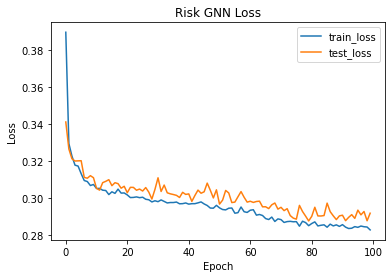

In [460]:

y_train = train_risk_loss.values()
x_train = train_risk_loss.keys()

y_loss = test_risk_loss.values()
x_loss = test_risk_loss.keys()
import matplotlib.pyplot as plt

plt.plot(x_train, y_train, label = "train_loss")
plt.plot(x_loss, y_loss, label = "test_loss")
plt.title('Risk GNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Reward model

In [457]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_reward.parameters(), lr=0.0001)

In [458]:
train_reward_loss = {}
test_reward_loss = {}
for epoch in range(100): 

    model_reward.train()
    loss = train_one_epoch(epoch, model_reward, train_loader, optimizer, loss_fn, label='reward')
    print(f"Epoch {epoch} | Train Loss {loss}")
    train_reward_loss[epoch] = loss


    # Testing
    model_reward.eval()
    t_loss = test(epoch, model_reward, test_loader, loss_fn, label='reward')
    print(f"Epoch {epoch} | Test Loss {t_loss}")
    train_reward_loss[epoch] = t_loss


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 202.39it/s]



 Confusion matrix: 
 [[12736  1743]
 [16622  2019]]
F1 Score: 0.18024371735928224
Accuracy: 0.4455012077294686
Precision: 0.10830964004077034
Recall: 0.5366826156299841
ROC AUC: 0.48524981656899435
Epoch 0 | Train Loss 0.7190422477929489


  1%|▊                                                                              | 21/2070 [00:00<00:09, 209.95it/s]

[[0.59748447]
 [0.5051325 ]
 [0.43618795]
 [0.5912109 ]
 [0.5283939 ]
 [0.45181233]
 [0.55512255]
 [0.44545704]
 [0.44409776]
 [0.45196977]]
[1. 1. 0. 1. 1. 0. 1. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[5757  757]
 [6897  788]]
F1 Score: 0.17074756229685809
Accuracy: 0.4609479540812733
Precision: 0.10253741054001302
Recall: 0.510032362459547
ROC AUC: 0.482493658707251
Epoch 0 | Test Loss 0.7136873119586223


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 202.02it/s]



 Confusion matrix: 
 [[13823  1887]
 [15534  1876]]
F1 Score: 0.17720682000661217
Accuracy: 0.4740036231884058
Precision: 0.10775416427340609
Recall: 0.4985384002125963
ROC AUC: 0.4846985695922811
Epoch 1 | Train Loss 0.7091918790110068


  1%|▊                                                                              | 20/2070 [00:00<00:10, 199.96it/s]

[[0.5882804 ]
 [0.49933004]
 [0.43138486]
 [0.5815724 ]
 [0.52148354]
 [0.44547   ]
 [0.55113804]
 [0.44014707]
 [0.43975314]
 [0.44743147]]
[1. 0. 0. 1. 1. 0. 1. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[6204  809]
 [6450  736]]
F1 Score: 0.1685946626961402
Accuracy: 0.48876681456440596
Precision: 0.1024213748956304
Recall: 0.47637540453074434
ROC AUC: 0.4833275789841963
Epoch 1 | Test Loss 0.7039391358156462


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 198.42it/s]



 Confusion matrix: 
 [[14854  2028]
 [14502  1736]]
F1 Score: 0.1735826417358264
Accuracy: 0.5009057971014492
Precision: 0.1069097179455598
Recall: 0.461211477151966
ROC AUC: 0.483603422184104
Epoch 2 | Train Loss 0.6997414426239217


  1%|▊                                                                              | 20/2070 [00:00<00:10, 190.43it/s]

[[0.5775356 ]
 [0.49329668]
 [0.42695066]
 [0.5723555 ]
 [0.5141074 ]
 [0.43908498]
 [0.5475244 ]
 [0.43529743]
 [0.43544185]
 [0.44295967]]
[1. 0. 0. 1. 1. 0. 1. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[6623  863]
 [6031  682]]
F1 Score: 0.1651731654153548
Accuracy: 0.5144728502007183
Precision: 0.10159392224042901
Recall: 0.4414239482200647
ROC AUC: 0.48240788054278083
Epoch 2 | Test Loss 0.6945698261260986


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 204.79it/s]



 Confusion matrix: 
 [[15841  2154]
 [13516  1609]]
F1 Score: 0.17037272342227872
Accuracy: 0.5268719806763285
Precision: 0.1063801652892562
Recall: 0.4275843741695456
ROC AUC: 0.4835915535050474
Epoch 3 | Train Loss 0.6906361561754476


  1%|▊                                                                              | 21/2070 [00:00<00:10, 201.88it/s]

[[0.5661612 ]
 [0.48779315]
 [0.4228846 ]
 [0.5640432 ]
 [0.5065023 ]
 [0.43317497]
 [0.54391664]
 [0.43104228]
 [0.43109447]
 [0.4385592 ]]
[1. 0. 0. 1. 1. 0. 1. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[7046  919]
 [5608  626]]
F1 Score: 0.1609461370356087
Accuracy: 0.5403197408268188
Precision: 0.10041706769329484
Recall: 0.4051779935275081
ROC AUC: 0.48099898570005883
Epoch 3 | Test Loss 0.6855377015229818


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 191.65it/s]



 Confusion matrix: 
 [[16768  2267]
 [12588  1497]]
F1 Score: 0.16774048966328645
Accuracy: 0.5514794685990339
Precision: 0.10628328008519702
Recall: 0.3977151965993624
ROC AUC: 0.48445509114611807
Epoch 4 | Train Loss 0.6818444016762978


  1%|▋                                                                              | 18/2070 [00:00<00:11, 174.72it/s]

[[0.55564374]
 [0.48255885]
 [0.41908514]
 [0.5562515 ]
 [0.4990567 ]
 [0.42821568]
 [0.5402236 ]
 [0.42701617]
 [0.426978  ]
 [0.43450826]]
[1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[7398  963]
 [5256  582]]
F1 Score: 0.15765948801300284
Accuracy: 0.5620114092541728
Precision: 0.09969167523124357
Recall: 0.3766990291262136
ROC AUC: 0.4806681489870044
Epoch 4 | Test Loss 0.6768513115139695


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 185.98it/s]



 Confusion matrix: 
 [[17637  2364]
 [11720  1399]]
F1 Score: 0.16573865655727993
Accuracy: 0.5747584541062802
Precision: 0.10663922555072795
Recall: 0.37177783683231463
ROC AUC: 0.48627724147369045
Epoch 5 | Train Loss 0.6733207683056449


  1%|▋                                                                              | 19/2070 [00:00<00:10, 188.08it/s]

[[0.548101  ]
 [0.4770607 ]
 [0.4155284 ]
 [0.5493208 ]
 [0.4922952 ]
 [0.4242491 ]
 [0.53652316]
 [0.4230333 ]
 [0.4230583 ]
 [0.43078375]]
[1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[7786 1002]
 [4868  543]]
F1 Score: 0.15612420931569868
Accuracy: 0.5865906049721812
Precision: 0.10035113657364628
Recall: 0.35145631067961164
ROC AUC: 0.48337791035798183
Epoch 5 | Test Loss 0.668459219707025


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.95it/s]



 Confusion matrix: 
 [[18429  2468]
 [10931  1292]]
F1 Score: 0.16167177626227866
Accuracy: 0.5954408212560387
Precision: 0.10570236439499305
Recall: 0.34361702127659577
ROC AUC: 0.48565387848570934
Epoch 6 | Train Loss 0.6650811235109965


  1%|▋                                                                              | 19/2070 [00:00<00:11, 180.91it/s]

[[0.54370725]
 [0.47053152]
 [0.41207242]
 [0.5426151 ]
 [0.48526943]
 [0.42076313]
 [0.5324891 ]
 [0.41884294]
 [0.4193575 ]
 [0.4272522 ]]
[1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[8072 1038]
 [4582  507]]
F1 Score: 0.15284895990352726
Accuracy: 0.6041974786956827
Precision: 0.09962664570642563
Recall: 0.32815533980582523
ROC AUC: 0.4830281993797579
Epoch 6 | Test Loss 0.660363137453526


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.73it/s]



 Confusion matrix: 
 [[19098  2569]
 [10258  1195]]
F1 Score: 0.15706118157324045
Accuracy: 0.6127113526570048
Precision: 0.10433947437352659
Recall: 0.31748140276301806
ROC AUC: 0.48402343744909315
Epoch 7 | Train Loss 0.6571374752095356


  1%|▋                                                                              | 19/2070 [00:00<00:11, 186.23it/s]

[[0.5406515 ]
 [0.46253383]
 [0.40867835]
 [0.5358237 ]
 [0.477505  ]
 [0.41755986]
 [0.5281622 ]
 [0.4144969 ]
 [0.41602415]
 [0.42392913]]
[1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[8347 1086]
 [4307  459]]
F1 Score: 0.14546030739977817
Accuracy: 0.6201845200366223
Precision: 0.09630717582878724
Recall: 0.2970873786407767
ROC AUC: 0.47836034808441563
Epoch 7 | Test Loss 0.6525598775159132


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.67it/s]



 Confusion matrix: 
 [[19854  2672]
 [ 9503  1091]]
F1 Score: 0.1519816117573309
Accuracy: 0.632397342995169
Precision: 0.10298282046441382
Recall: 0.2899282487377093
ROC AUC: 0.48311175525756944
Epoch 8 | Train Loss 0.6494380915798427


  1%|▋                                                                              | 19/2070 [00:00<00:10, 188.04it/s]

[[0.5381846 ]
 [0.4542146 ]
 [0.40566865]
 [0.5295322 ]
 [0.4703726 ]
 [0.4145939 ]
 [0.52394336]
 [0.41033638]
 [0.4130312 ]
 [0.4207718 ]]
[1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[8722 1138]
 [3932  407]]
F1 Score: 0.13834126444595513
Accuracy: 0.6429326008873865
Precision: 0.09380041484212952
Recall: 0.2634304207119741
ROC AUC: 0.4763493181479896
Epoch 8 | Test Loss 0.6449493671859707


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 185.67it/s]



 Confusion matrix: 
 [[20852  2800]
 [ 8505   963]]
F1 Score: 0.14556722847857304
Accuracy: 0.6586654589371981
Precision: 0.10171102661596958
Recall: 0.25591283550358757
ROC AUC: 0.4831016982641077
Epoch 9 | Train Loss 0.6419890574499029


  1%|▋                                                                              | 19/2070 [00:00<00:11, 182.65it/s]

[[0.535305  ]
 [0.44559324]
 [0.4028411 ]
 [0.5235143 ]
 [0.46303004]
 [0.41179222]
 [0.519835  ]
 [0.40664333]
 [0.41027343]
 [0.41781646]]
[1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[9208 1204]
 [3446  341]]
F1 Score: 0.12790697674418602
Accuracy: 0.6725121487428692
Precision: 0.09004489041457618
Recall: 0.22071197411003235
ROC AUC: 0.47419350878727473
Epoch 9 | Test Loss 0.6375607458857803


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 187.06it/s]



 Confusion matrix: 
 [[22060  2953]
 [ 7296   811]]
F1 Score: 0.1366354982731025
Accuracy: 0.6905495169082125
Precision: 0.10003700505735784
Recall: 0.21546227417640806
ROC AUC: 0.48346352569700635
Epoch 10 | Train Loss 0.634786035358042


  1%|▊                                                                              | 20/2070 [00:00<00:10, 192.27it/s]

[[0.53105944]
 [0.43706903]
 [0.39989132]
 [0.5177496 ]
 [0.45576176]
 [0.40919217]
 [0.5155001 ]
 [0.4035106 ]
 [0.4076887 ]
 [0.41504076]]
[1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[9765 1280]
 [2889  265]]
F1 Score: 0.11278995530964034
Accuracy: 0.7063877737868864
Precision: 0.08402029169308814
Recall: 0.1715210355987055
ROC AUC: 0.4716068904878307
Epoch 10 | Test Loss 0.63045045223322


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.54it/s]



 Confusion matrix: 
 [[23409  3133]
 [ 5947   631]]
F1 Score: 0.12202668729452716
Accuracy: 0.7258454106280193
Precision: 0.09592581331711766
Recall: 0.16764080765143463
ROC AUC: 0.4825293559990379
Epoch 11 | Train Loss 0.6278366419140268


  1%|▋                                                                              | 18/2070 [00:00<00:11, 178.13it/s]

[[0.525914  ]
 [0.43006566]
 [0.397212  ]
 [0.5117137 ]
 [0.44811094]
 [0.40676457]
 [0.51058286]
 [0.40099704]
 [0.4052458 ]
 [0.41238156]]
[1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[10398  1347]
 [ 2256   198]]
F1 Score: 0.09902475618904724
Accuracy: 0.7462497358968941
Precision: 0.08068459657701711
Recall: 0.12815533980582525
ROC AUC: 0.47493589655061297
Epoch 11 | Test Loss 0.6235916729982909


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 187.03it/s]



 Confusion matrix: 
 [[24827  3303]
 [ 4529   461]]
F1 Score: 0.10532328078592644
Accuracy: 0.7635265700483091
Precision: 0.09238476953907816
Recall: 0.12247608926673752
ROC AUC: 0.48409878860393696
Epoch 12 | Train Loss 0.6211507508144286


  1%|▊                                                                              | 20/2070 [00:00<00:10, 192.26it/s]

[[0.52065647]
 [0.42445123]
 [0.39500657]
 [0.5048764 ]
 [0.44145596]
 [0.4044094 ]
 [0.5050821 ]
 [0.39866522]
 [0.4029162 ]
 [0.4098236 ]]
[1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[10981  1403]
 [ 1673   142]]
F1 Score: 0.08452380952380953
Accuracy: 0.7833650257060356
Precision: 0.07823691460055096
Recall: 0.09190938511326861
ROC AUC: 0.4798491132931603
Epoch 12 | Test Loss 0.6169295791570131


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 185.68it/s]



 Confusion matrix: 
 [[26077  3432]
 [ 3280   331]]
F1 Score: 0.0897748847301329
Accuracy: 0.7973429951690821
Precision: 0.09166435890335087
Recall: 0.08796173266011162
ROC AUC: 0.4881168475270446
Epoch 13 | Train Loss 0.6146409345133869


  1%|▋                                                                              | 19/2070 [00:00<00:10, 188.05it/s]

[[0.51655823]
 [0.4194722 ]
 [0.3931656 ]
 [0.49641705]
 [0.43618014]
 [0.40212002]
 [0.4991876 ]
 [0.39625713]
 [0.4006701 ]
 [0.4073812 ]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[11421  1443]
 [ 1233   102]]
F1 Score: 0.07083333333333333
Accuracy: 0.8115360236636383
Precision: 0.07640449438202247
Recall: 0.06601941747572816
ROC AUC: 0.4842899363338812
Epoch 13 | Test Loss 0.6104994947845871


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.76it/s]



 Confusion matrix: 
 [[27035  3527]
 [ 2322   236]]
F1 Score: 0.07467172915677898
Accuracy: 0.8233997584541063
Precision: 0.09225957779515247
Recall: 0.0627159181504119
ROC AUC: 0.491810321373806
Epoch 14 | Train Loss 0.6084146047271968


  1%|▋                                                                              | 19/2070 [00:00<00:10, 188.05it/s]

[[0.5128941 ]
 [0.4144621 ]
 [0.3914658 ]
 [0.487507  ]
 [0.43058345]
 [0.39999664]
 [0.49339446]
 [0.39386523]
 [0.3985482 ]
 [0.40506262]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[11791  1473]
 [  863    72]]
F1 Score: 0.05806451612903226
Accuracy: 0.8354813719276005
Precision: 0.07700534759358289
Recall: 0.04660194174757282
ROC AUC: 0.48920108151073916
Epoch 14 | Test Loss 0.6043231621518865


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.98it/s]



 Confusion matrix: 
 [[27786  3611]
 [ 1570   153]]
F1 Score: 0.055768179332968834
Accuracy: 0.8435688405797102
Precision: 0.08879860708067325
Recall: 0.040648246546227416
ROC AUC: 0.4935834229052162
Epoch 15 | Train Loss 0.6024509177691695


  1%|▋                                                                              | 19/2070 [00:00<00:11, 182.65it/s]

[[0.5088761 ]
 [0.4099273 ]
 [0.38980672]
 [0.47919777]
 [0.42305437]
 [0.39798954]
 [0.48811796]
 [0.39172655]
 [0.39652476]
 [0.40286213]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12106  1499]
 [  548    46]]
F1 Score: 0.04301075268817204
Accuracy: 0.8558349179519684
Precision: 0.07744107744107744
Recall: 0.02977346278317152
ROC AUC: 0.49323349921203785
Epoch 15 | Test Loss 0.5984100425565565


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.66it/s]



 Confusion matrix: 
 [[28348  3680]
 [ 1008    84]]
F1 Score: 0.03459637561779243
Accuracy: 0.8584541062801933
Precision: 0.07692307692307693
Recall: 0.022316684378320937
ROC AUC: 0.49398979061537657
Epoch 16 | Train Loss 0.5967507358334491


  1%|▋                                                                              | 19/2070 [00:00<00:11, 184.43it/s]

[[0.5037127 ]
 [0.40649256]
 [0.3882734 ]
 [0.47133726]
 [0.41641572]
 [0.39604762]
 [0.48293844]
 [0.38978484]
 [0.39451593]
 [0.40076816]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12288  1520]
 [  366    25]]
F1 Score: 0.025826446280991733
Accuracy: 0.8671737446299035
Precision: 0.0639386189258312
Recall: 0.016181229773462782
ROC AUC: 0.4936287846354274
Epoch 16 | Test Loss 0.5927689456724906


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.48it/s]



 Confusion matrix: 
 [[28716  3712]
 [  643    49]]
F1 Score: 0.02200763530204357
Accuracy: 0.8685084541062802
Precision: 0.0708092485549133
Recall: 0.01302844988035097
ROC AUC: 0.49556357948222396
Epoch 17 | Train Loss 0.5912874220074087


  1%|▋                                                                              | 19/2070 [00:00<00:11, 182.66it/s]

[[0.49696487]
 [0.4034267 ]
 [0.38684976]
 [0.46354398]
 [0.4120136 ]
 [0.3942086 ]
 [0.4775796 ]
 [0.38788623]
 [0.39255142]
 [0.39874974]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12443  1537]
 [  211     8]]
F1 Score: 0.009070294784580499
Accuracy: 0.8768927389252764
Precision: 0.0365296803652968
Recall: 0.005177993527508091
ROC AUC: 0.49425171211067986
Epoch 17 | Test Loss 0.5874195780840006


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.39it/s]



 Confusion matrix: 
 [[29000  3737]
 [  358    25]]
F1 Score: 0.012062726176115802
Accuracy: 0.876358695652174
Precision: 0.06527415143603134
Recall: 0.006645401382243487
ROC AUC: 0.49722555510899763
Epoch 18 | Train Loss 0.5861634996778147


  1%|▋                                                                              | 18/2070 [00:00<00:11, 176.43it/s]

[[0.48980546]
 [0.4003082 ]
 [0.385439  ]
 [0.45507985]
 [0.40839204]
 [0.39248034]
 [0.47262064]
 [0.3859822 ]
 [0.39070332]
 [0.39676708]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12532  1542]
 [  122     3]]
F1 Score: 0.0035928143712574846
Accuracy: 0.882808648496373
Precision: 0.024
Recall: 0.001941747572815534
ROC AUC: 0.4961502637026398
Epoch 18 | Test Loss 0.5823261117612993


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.61it/s]



 Confusion matrix: 
 [[29177  3749]
 [  180    14]]
F1 Score: 0.0070760677280768255
Accuracy: 0.88137077294686
Precision: 0.07216494845360824
Recall: 0.0037204358224820623
ROC AUC: 0.49879450956229526
Epoch 19 | Train Loss 0.5812818866421059


  1%|▋                                                                              | 19/2070 [00:00<00:11, 182.65it/s]

[[0.48234576]
 [0.397374  ]
 [0.3840292 ]
 [0.44663578]
 [0.40466028]
 [0.39082605]
 [0.46800637]
 [0.3841491 ]
 [0.38900378]
 [0.39480752]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12582  1543]
 [   72     2]]
F1 Score: 0.0024706609017912293
Accuracy: 0.8862595957461793
Precision: 0.02702702702702703
Recall: 0.0012944983818770227
ROC AUC: 0.4978022989775672
Epoch 19 | Test Loss 0.5774928712630057


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.44it/s]



 Confusion matrix: 
 [[29258  3757]
 [   98     7]]
F1 Score: 0.0036185060739209094
Accuracy: 0.8836050724637681
Precision: 0.06666666666666667
Recall: 0.0018597236981934113
ROC AUC: 0.4992606971127566
Epoch 20 | Train Loss 0.5766781536709283


  1%|▋                                                                              | 18/2070 [00:00<00:11, 179.96it/s]

[[0.47367483]
 [0.394769  ]
 [0.38266116]
 [0.43836084]
 [0.40086967]
 [0.38921508]
 [0.46323237]
 [0.38243482]
 [0.3873784 ]
 [0.39286557]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12615  1543]
 [   39     2]]
F1 Score: 0.0025220680958385876
Accuracy: 0.8885837030776815
Precision: 0.04878048780487805
Recall: 0.0012944983818770227
ROC AUC: 0.49910623449202907
Epoch 20 | Test Loss 0.5729442730143264


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 187.44it/s]



 Confusion matrix: 
 [[29313  3759]
 [   44     4]]
F1 Score: 0.0020991865652059826
Accuracy: 0.8851751207729469
Precision: 0.08333333333333333
Recall: 0.0010629816635663034
ROC AUC: 0.49978209545759644
Epoch 21 | Train Loss 0.5723202071040149


  1%|▋                                                                              | 18/2070 [00:00<00:11, 178.18it/s]

[[0.46446553]
 [0.39233297]
 [0.38135934]
 [0.43021724]
 [0.3969197 ]
 [0.38759977]
 [0.4581096 ]
 [0.3808638 ]
 [0.3857398 ]
 [0.39095125]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12636  1544]
 [   18     1]]
F1 Score: 0.001278772378516624
Accuracy: 0.8899922529755616
Precision: 0.05263157894736842
Recall: 0.0006472491909385113
ROC AUC: 0.4996123870421265
Epoch 21 | Test Loss 0.5686570996636743


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 185.28it/s]



 Confusion matrix: 
 [[29338  3763]
 [   19     0]]
F1 Score: 0.0
Accuracy: 0.8858091787439614
Precision: 0.0
Recall: 0.0
ROC AUC: 0.4996763974520557
Epoch 22 | Train Loss 0.5682495208322138


  1%|▋                                                                              | 18/2070 [00:00<00:11, 178.17it/s]

[[0.45627844]
 [0.3901501 ]
 [0.38012218]
 [0.42313606]
 [0.39373776]
 [0.38592678]
 [0.45312446]
 [0.3794271 ]
 [0.38407254]
 [0.38907614]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12647  1545]
 [    7     0]]
F1 Score: 0.0
Accuracy: 0.8906965279245017
Precision: 0.0
Recall: 0.0
ROC AUC: 0.49972340761814443
Epoch 22 | Test Loss 0.5646282837197587


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 183.96it/s]



 Confusion matrix: 
 [[29349  3762]
 [    9     0]]
F1 Score: 0.0
Accuracy: 0.8861413043478261
Precision: 0.0
Recall: 0.0
ROC AUC: 0.49984671980380135
Epoch 23 | Train Loss 0.5644085773811248


  1%|▋                                                                              | 19/2070 [00:00<00:10, 188.09it/s]

[[0.4495173 ]
 [0.3880745 ]
 [0.37893054]
 [0.4176681 ]
 [0.39110675]
 [0.38421494]
 [0.448319  ]
 [0.37807825]
 [0.3824231 ]
 [0.38730323]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12652  1545]
 [    2     0]]
F1 Score: 0.0
Accuracy: 0.8910486653989718
Precision: 0.0
Recall: 0.0
ROC AUC: 0.4999209736051841
Epoch 23 | Test Loss 0.560846181334676


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 184.60it/s]



 Confusion matrix: 
 [[29351  3763]
 [    6     0]]
F1 Score: 0.0
Accuracy: 0.886201690821256
Precision: 0.0
Recall: 0.0
ROC AUC: 0.49989780972170184
Epoch 24 | Train Loss 0.5608140368968393


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:10, 188.05it/s]

[[0.44360098]
 [0.38579133]
 [0.37775663]
 [0.41256654]
 [0.38857618]
 [0.3825763 ]
 [0.44333127]
 [0.3767975 ]
 [0.3808124 ]
 [0.38565198]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 24 | Test Loss 0.5572753081450591


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.98it/s]



 Confusion matrix: 
 [[29353  3764]
 [    3     0]]
F1 Score: 0.0
Accuracy: 0.886262077294686
Precision: 0.0
Recall: 0.0
ROC AUC: 0.49994890312031615
Epoch 25 | Train Loss 0.5574232092802075


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▊                                                                              | 20/2070 [00:00<00:10, 196.05it/s]

[[0.4378099 ]
 [0.38305235]
 [0.37661424]
 [0.40656352]
 [0.38623473]
 [0.38109186]
 [0.43806168]
 [0.37557608]
 [0.37924945]
 [0.38410756]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 25 | Test Loss 0.5539145563636814


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.88it/s]



 Confusion matrix: 
 [[29356  3763]
 [    1     0]]
F1 Score: 0.0
Accuracy: 0.8863526570048309
Precision: 0.0
Recall: 0.0
ROC AUC: 0.4999829682869503
Epoch 26 | Train Loss 0.5542033417789256


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 18/2070 [00:00<00:11, 179.96it/s]

[[0.4321958 ]
 [0.38015485]
 [0.37549803]
 [0.40120906]
 [0.38409033]
 [0.37970373]
 [0.43303213]
 [0.37439567]
 [0.3777653 ]
 [0.38264206]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 26 | Test Loss 0.5507491582685763


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.89it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29356  3764]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863526570048309
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 27 | Train Loss 0.5511980088580634


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 18/2070 [00:00<00:11, 178.18it/s]

[[0.42705026]
 [0.37764713]
 [0.37439382]
 [0.397246  ]
 [0.38175547]
 [0.37832242]
 [0.42888096]
 [0.3732408 ]
 [0.3763588 ]
 [0.38122785]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 27 | Test Loss 0.5477587105454625


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.19it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 28 | Train Loss 0.5483411251922736


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:11, 184.42it/s]

[[0.42232782]
 [0.37566918]
 [0.37330285]
 [0.39395925]
 [0.37920323]
 [0.37689292]
 [0.42547375]
 [0.3721093 ]
 [0.3749897 ]
 [0.37985444]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 28 | Test Loss 0.5449420401641915


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.69it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 29 | Train Loss 0.5456540987543438


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▊                                                                              | 20/2070 [00:00<00:10, 190.44it/s]

[[0.4183449 ]
 [0.3740275 ]
 [0.3722047 ]
 [0.3909398 ]
 [0.37694094]
 [0.37541413]
 [0.42251605]
 [0.37100726]
 [0.37363356]
 [0.37849957]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 29 | Test Loss 0.5422670368675713


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.09it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29358  3762]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8864130434782609
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 30 | Train Loss 0.543084075672615


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 18/2070 [00:00<00:11, 176.43it/s]

[[0.41520464]
 [0.37252852]
 [0.3711137 ]
 [0.3880845 ]
 [0.37504935]
 [0.3739755 ]
 [0.41979638]
 [0.36994383]
 [0.37232363]
 [0.37717104]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 30 | Test Loss 0.5397163042882541


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 183.46it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29358  3762]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8864130434782609
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 31 | Train Loss 0.5406341764230083


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 18/2070 [00:00<00:11, 174.72it/s]

[[0.41264033]
 [0.3711426 ]
 [0.3700449 ]
 [0.38537323]
 [0.37343568]
 [0.3725824 ]
 [0.4170825 ]
 [0.36890826]
 [0.37106612]
 [0.3758525 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 31 | Test Loss 0.537269838355683


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 185.79it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29356  3764]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863526570048309
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 32 | Train Loss 0.5383111806163465


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▊                                                                              | 20/2070 [00:00<00:10, 192.26it/s]

[[0.41024995]
 [0.36989242]
 [0.36900434]
 [0.3827016 ]
 [0.37186626]
 [0.37122047]
 [0.41425756]
 [0.367897  ]
 [0.36986762]
 [0.37453657]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 32 | Test Loss 0.5349226326824309


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 185.73it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29356  3764]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863526570048309
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 33 | Train Loss 0.536057753637793


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:11, 184.42it/s]

[[0.40772036]
 [0.3687257 ]
 [0.36799243]
 [0.38041723]
 [0.37033376]
 [0.36992487]
 [0.41140315]
 [0.36691245]
 [0.36871287]
 [0.37321743]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 33 | Test Loss 0.5326709469427934


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.73it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 34 | Train Loss 0.5338534133013896


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:11, 184.41it/s]

[[0.40518874]
 [0.36759734]
 [0.36698642]
 [0.37842134]
 [0.36889753]
 [0.3687063 ]
 [0.40853128]
 [0.36593327]
 [0.36755863]
 [0.3718707 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 34 | Test Loss 0.5304843292043016


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.40it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 35 | Train Loss 0.531725733478864


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 18/2070 [00:00<00:11, 178.18it/s]

[[0.4028297 ]
 [0.36651653]
 [0.3659907 ]
 [0.37651235]
 [0.3675813 ]
 [0.3675621 ]
 [0.40558875]
 [0.36496323]
 [0.36641118]
 [0.3705269 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 35 | Test Loss 0.5283626414634086


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 187.04it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 36 | Train Loss 0.5296654022114289


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 18/2070 [00:00<00:11, 179.96it/s]

[[0.40053958]
 [0.36546743]
 [0.3650012 ]
 [0.37459853]
 [0.36637598]
 [0.36646006]
 [0.4026585 ]
 [0.3639996 ]
 [0.36530364]
 [0.36920917]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 36 | Test Loss 0.5263021423204525


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 187.72it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29356  3764]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863526570048309
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 37 | Train Loss 0.52768163178566


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:10, 188.08it/s]

[[0.39826447]
 [0.36443612]
 [0.36402008]
 [0.37260452]
 [0.3652249 ]
 [0.3653803 ]
 [0.39977673]
 [0.36304623]
 [0.3642512 ]
 [0.36794   ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 37 | Test Loss 0.5242948324025214


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.34it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29356  3764]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863526570048309
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 38 | Train Loss 0.525738066981956


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:10, 188.08it/s]

[[0.39590186]
 [0.36340857]
 [0.36304387]
 [0.37057623]
 [0.36410043]
 [0.36430797]
 [0.39692143]
 [0.362098  ]
 [0.36323798]
 [0.36673436]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 38 | Test Loss 0.522345669768952


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 185.04it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29358  3762]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8864130434782609
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 39 | Train Loss 0.5238213897039349


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:10, 188.05it/s]

[[0.39313826]
 [0.36237052]
 [0.36207065]
 [0.36857173]
 [0.36298865]
 [0.36324185]
 [0.3938881 ]
 [0.3611511 ]
 [0.362242  ]
 [0.36557996]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 39 | Test Loss 0.5204492110658336


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.86it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29359  3761]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8864432367149758
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 40 | Train Loss 0.5219641734868432


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:11, 180.91it/s]

[[0.39000192]
 [0.36131892]
 [0.3611035 ]
 [0.36674008]
 [0.36186498]
 [0.36219403]
 [0.39004585]
 [0.36020783]
 [0.36125657]
 [0.3644617 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 40 | Test Loss 0.5186064192303667


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.30it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 41 | Train Loss 0.520219955884892


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:11, 182.65it/s]

[[0.38664412]
 [0.36027145]
 [0.36014548]
 [0.36512756]
 [0.36078933]
 [0.36116764]
 [0.38553545]
 [0.35927165]
 [0.360283  ]
 [0.36337054]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 41 | Test Loss 0.5168306893325066


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.16it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29359  3761]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8864432367149758
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 42 | Train Loss 0.5184689518190236


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:11, 186.23it/s]

[[0.38310984]
 [0.3592372 ]
 [0.35918447]
 [0.36362433]
 [0.35973695]
 [0.36014593]
 [0.38123998]
 [0.35833293]
 [0.35930857]
 [0.36228395]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 42 | Test Loss 0.5151033957262297


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.71it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29356  3764]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863526570048309
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 43 | Train Loss 0.5168535704917954


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:10, 188.08it/s]

[[0.37972695]
 [0.35823748]
 [0.35823065]
 [0.36213842]
 [0.35868084]
 [0.35913694]
 [0.37745717]
 [0.35740224]
 [0.3583444 ]
 [0.361206  ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 43 | Test Loss 0.513437244269225


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 185.77it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 44 | Train Loss 0.5152345399205811


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:11, 186.23it/s]

[[0.37675843]
 [0.35725692]
 [0.35727942]
 [0.3606188 ]
 [0.3576651 ]
 [0.358133  ]
 [0.3739388 ]
 [0.35647547]
 [0.3573883 ]
 [0.36013356]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 44 | Test Loss 0.5118252004052067


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 187.22it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29356  3764]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863526570048309
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 45 | Train Loss 0.5136955359707708


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:11, 182.65it/s]

[[0.37392533]
 [0.3562832 ]
 [0.35632867]
 [0.3591796 ]
 [0.35668525]
 [0.35712957]
 [0.37079358]
 [0.35554957]
 [0.35643762]
 [0.3590664 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 45 | Test Loss 0.5102627059897861


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.68it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 46 | Train Loss 0.5121755739197063


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:11, 186.21it/s]

[[0.3710259 ]
 [0.35531887]
 [0.3553833 ]
 [0.35786524]
 [0.35571277]
 [0.35613248]
 [0.36820745]
 [0.35462868]
 [0.35549617]
 [0.3580118 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 46 | Test Loss 0.5087617861258017


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.36it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 47 | Train Loss 0.510719219699574


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 18/2070 [00:00<00:11, 179.96it/s]

[[0.36803904]
 [0.35435614]
 [0.3544361 ]
 [0.35663486]
 [0.35474294]
 [0.3551359 ]
 [0.36610377]
 [0.35370538]
 [0.3545556 ]
 [0.35696256]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 47 | Test Loss 0.5073050749194514


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 186.14it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29356  3764]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863526570048309
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 48 | Train Loss 0.5093328680825119


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:10, 189.95it/s]

[[0.36507773]
 [0.3533955 ]
 [0.35349378]
 [0.3554722 ]
 [0.35379076]
 [0.35414916]
 [0.3642669 ]
 [0.35278654]
 [0.3536214 ]
 [0.35592166]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 48 | Test Loss 0.5059040537825575


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 187.32it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29356  3764]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863526570048309
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 49 | Train Loss 0.5079762682822592


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▊                                                                              | 20/2070 [00:00<00:10, 194.11it/s]

[[0.36235443]
 [0.35242385]
 [0.35254833]
 [0.35434777]
 [0.35284388]
 [0.3531605 ]
 [0.36249706]
 [0.3518648 ]
 [0.3526837 ]
 [0.35486913]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 49 | Test Loss 0.5045390251252029


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 183.12it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 50 | Train Loss 0.5066383733265641


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▍                                                                              | 12/2070 [00:00<00:18, 112.12it/s]

[[0.3601254 ]
 [0.35145485]
 [0.35160568]
 [0.3532456 ]
 [0.35189977]
 [0.35217592]
 [0.36072117]
 [0.35094702]
 [0.35174826]
 [0.35380536]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 50 | Test Loss 0.5032175561866244


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:13<00:00, 148.82it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 51 | Train Loss 0.5053578745339804


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▌                                                                              | 14/2070 [00:00<00:14, 139.97it/s]

[[0.3583358 ]
 [0.35049936]
 [0.3506638 ]
 [0.35214368]
 [0.3509554 ]
 [0.3511915 ]
 [0.35886332]
 [0.35003102]
 [0.35081306]
 [0.35272503]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 51 | Test Loss 0.5019291949433249


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:13<00:00, 154.44it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29358  3762]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8864130434782609
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 52 | Train Loss 0.5040975382074642


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▌                                                                              | 15/2070 [00:00<00:14, 144.20it/s]

[[0.3567999 ]
 [0.34956047]
 [0.34972864]
 [0.35107496]
 [0.35001978]
 [0.35021067]
 [0.35701662]
 [0.34912196]
 [0.34988397]
 [0.35163984]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 52 | Test Loss 0.5006792041900996


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:13<00:00, 151.65it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 53 | Train Loss 0.5029057092424752


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▌                                                                              | 16/2070 [00:00<00:12, 159.96it/s]

[[0.35538164]
 [0.34862012]
 [0.3487883 ]
 [0.3500455 ]
 [0.3490803 ]
 [0.34921935]
 [0.35533416]
 [0.34820828]
 [0.34894997]
 [0.3505514 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 53 | Test Loss 0.49945713740748326


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:13<00:00, 152.22it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29358  3762]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8864130434782609
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 54 | Train Loss 0.5017062052148552


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▌                                                                              | 16/2070 [00:00<00:13, 156.83it/s]

[[0.3540274 ]
 [0.34767577]
 [0.3478443 ]
 [0.3490378 ]
 [0.34813792]
 [0.34821954]
 [0.35384402]
 [0.34729233]
 [0.34801316]
 [0.34947342]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 54 | Test Loss 0.4982611187943467


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:13<00:00, 152.91it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 55 | Train Loss 0.5005714107826712


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 18/2070 [00:00<00:11, 171.39it/s]

[[0.35270667]
 [0.3467311 ]
 [0.34690028]
 [0.34803247]
 [0.34719735]
 [0.34721994]
 [0.3524723 ]
 [0.34637907]
 [0.34707853]
 [0.34841806]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 55 | Test Loss 0.4970918151440921


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:12<00:00, 164.50it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29358  3762]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8864130434782609
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 56 | Train Loss 0.4994195074994783


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▌                                                                              | 16/2070 [00:00<00:12, 158.38it/s]

[[0.35137385]
 [0.34578434]
 [0.34595156]
 [0.34701526]
 [0.3462532 ]
 [0.3462218 ]
 [0.35115698]
 [0.34546435]
 [0.34614116]
 [0.34737596]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 56 | Test Loss 0.4959411717749931


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:12<00:00, 164.14it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 57 | Train Loss 0.4983256282005909


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 17/2070 [00:00<00:12, 161.87it/s]

[[0.35000023]
 [0.3448418 ]
 [0.3450015 ]
 [0.3460039 ]
 [0.34530878]
 [0.3452333 ]
 [0.34988368]
 [0.34455034]
 [0.34520423]
 [0.34634313]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 57 | Test Loss 0.4948100451682065


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:12<00:00, 164.27it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29359  3761]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8864432367149758
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 58 | Train Loss 0.4971924908639152


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▌                                                                              | 16/2070 [00:00<00:12, 158.38it/s]

[[0.3486091 ]
 [0.34390518]
 [0.3440507 ]
 [0.34501576]
 [0.34436247]
 [0.34425214]
 [0.34863526]
 [0.34363583]
 [0.34426627]
 [0.34531158]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 58 | Test Loss 0.4936977110736005


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:12<00:00, 164.53it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 59 | Train Loss 0.4961522912201674


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 17/2070 [00:00<00:12, 168.26it/s]

[[0.347308  ]
 [0.3429742 ]
 [0.34310272]
 [0.34403622]
 [0.34341478]
 [0.34327936]
 [0.34739646]
 [0.3427223 ]
 [0.34332758]
 [0.3442832 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 59 | Test Loss 0.4926012208064397


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:12<00:00, 165.82it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29359  3761]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8864432367149758
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 60 | Train Loss 0.4950525940472377


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 17/2070 [00:00<00:12, 165.02it/s]

[[0.34613797]
 [0.34204957]
 [0.34216028]
 [0.34305573]
 [0.34247074]
 [0.34231782]
 [0.34620363]
 [0.34181267]
 [0.34239262]
 [0.34326264]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 60 | Test Loss 0.49152413426755787


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:12<00:00, 164.99it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29356  3764]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863526570048309
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 61 | Train Loss 0.4940630502890849


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 17/2070 [00:00<00:12, 166.63it/s]

[[0.3450294 ]
 [0.3411242 ]
 [0.34121704]
 [0.34206083]
 [0.3415228 ]
 [0.3413623 ]
 [0.3450718 ]
 [0.34090164]
 [0.34145465]
 [0.34224337]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 61 | Test Loss 0.4904555090375849


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:12<00:00, 166.51it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29356  3764]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863526570048309
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 62 | Train Loss 0.4930268722023941


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▌                                                                              | 16/2070 [00:00<00:12, 158.38it/s]

[[0.34396613]
 [0.34020346]
 [0.3402774 ]
 [0.34106383]
 [0.34057832]
 [0.34041607]
 [0.34398943]
 [0.33999458]
 [0.34052095]
 [0.3412346 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 62 | Test Loss 0.4894017279148102


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:12<00:00, 164.04it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 63 | Train Loss 0.4919864002345265


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 17/2070 [00:00<00:12, 163.43it/s]

[[0.34292832]
 [0.33928746]
 [0.33934253]
 [0.34008276]
 [0.33963788]
 [0.33947676]
 [0.34292504]
 [0.33909193]
 [0.33959186]
 [0.34023786]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 63 | Test Loss 0.48836200019797765


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:12<00:00, 164.66it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 64 | Train Loss 0.49097186493988776


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▌                                                                              | 16/2070 [00:00<00:12, 159.95it/s]

[[0.34188443]
 [0.3383675 ]
 [0.33840528]
 [0.33911198]
 [0.3386936 ]
 [0.33853263]
 [0.34183633]
 [0.33818546]
 [0.33865905]
 [0.33924404]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 64 | Test Loss 0.48732755232501673


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:12<00:00, 164.96it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 65 | Train Loss 0.4899700052352343


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▌                                                                              | 16/2070 [00:00<00:12, 159.96it/s]

[[0.34079558]
 [0.33745492]
 [0.33747956]
 [0.33815256]
 [0.33775687]
 [0.33759424]
 [0.3407248 ]
 [0.33728662]
 [0.33773354]
 [0.3382662 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 65 | Test Loss 0.48630810468583496


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:12<00:00, 170.99it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 66 | Train Loss 0.4889797946393202


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 18/2070 [00:00<00:11, 176.43it/s]

[[0.33964428]
 [0.33654726]
 [0.33656198]
 [0.33718634]
 [0.33682388]
 [0.3366615 ]
 [0.33962238]
 [0.33639172]
 [0.3368126 ]
 [0.33729723]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 66 | Test Loss 0.4852995750334886


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 182.95it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29358  3762]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8864130434782609
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 67 | Train Loss 0.487978949221436


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:11, 182.60it/s]

[[0.33846384]
 [0.33564335]
 [0.3356505 ]
 [0.3361992 ]
 [0.33589295]
 [0.3357353 ]
 [0.33855262]
 [0.3354988 ]
 [0.33589494]
 [0.33633703]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 67 | Test Loss 0.4843007220072789


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 183.79it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29358  3762]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8864130434782609
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 68 | Train Loss 0.4870079153113895


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:11, 180.94it/s]

[[0.3372187 ]
 [0.33474395]
 [0.3347455 ]
 [0.33519855]
 [0.3349652 ]
 [0.334817  ]
 [0.3375069 ]
 [0.33460942]
 [0.33498144]
 [0.33538693]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 68 | Test Loss 0.4833119181362358


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 184.02it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29358  3762]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8864130434782609
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 69 | Train Loss 0.48604669563724223


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 18/2070 [00:00<00:11, 178.18it/s]

[[0.3358834 ]
 [0.33384788]
 [0.33384535]
 [0.334206  ]
 [0.3340404 ]
 [0.33390525]
 [0.33648008]
 [0.33372346]
 [0.33407074]
 [0.33444685]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 69 | Test Loss 0.48233220518172326


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 185.42it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 70 | Train Loss 0.4851139332793185


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:11, 184.44it/s]

[[0.33452582]
 [0.33295277]
 [0.33294702]
 [0.33322865]
 [0.3331194 ]
 [0.33299702]
 [0.33547303]
 [0.33283824]
 [0.33316118]
 [0.33351278]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 70 | Test Loss 0.481359484630662


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 185.62it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 71 | Train Loss 0.4841708503195629


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 18/2070 [00:00<00:11, 179.96it/s]

[[0.33327776]
 [0.33206448]
 [0.3320563 ]
 [0.3322846 ]
 [0.3322096 ]
 [0.33209822]
 [0.33448398]
 [0.33195916]
 [0.33225933]
 [0.33258945]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 71 | Test Loss 0.4804007270046183


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 181.23it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 72 | Train Loss 0.48323839714273736


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 18/2070 [00:00<00:11, 173.04it/s]

[[0.3321534 ]
 [0.3311792 ]
 [0.33116937]
 [0.33136576]
 [0.3313062 ]
 [0.33120605]
 [0.3334958 ]
 [0.33108264]
 [0.33136132]
 [0.33167174]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 72 | Test Loss 0.4794508449666135


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 184.53it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29359  3761]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8864432367149758
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 73 | Train Loss 0.48227459732173145


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▊                                                                              | 20/2070 [00:00<00:10, 196.03it/s]

[[0.33111277]
 [0.33029974]
 [0.33028907]
 [0.3304636 ]
 [0.33041072]
 [0.33032244]
 [0.33250362]
 [0.33021134]
 [0.3304699 ]
 [0.3307618 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 73 | Test Loss 0.4785121159779059


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 197.74it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 74 | Train Loss 0.4814035945900396


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▊                                                                              | 21/2070 [00:00<00:09, 209.95it/s]

[[0.33012688]
 [0.32942128]
 [0.32941037]
 [0.32956696]
 [0.32951742]
 [0.32944182]
 [0.33150348]
 [0.32934007]
 [0.32958037]
 [0.3298545 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 74 | Test Loss 0.4775801231195261


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 198.98it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 75 | Train Loss 0.480500813483616


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:11, 186.23it/s]

[[0.32917488]
 [0.32854813]
 [0.32853773]
 [0.32867706]
 [0.3286303 ]
 [0.32856765]
 [0.3305131 ]
 [0.3284735 ]
 [0.32869673]
 [0.3289543 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 75 | Test Loss 0.47665945353271727


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 196.16it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29358  3762]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8864130434782609
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 76 | Train Loss 0.47958125705304355


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:10, 188.08it/s]

[[0.32822713]
 [0.32767382]
 [0.3276642 ]
 [0.32778472]
 [0.32774246]
 [0.32769287]
 [0.32953286]
 [0.32760525]
 [0.32781234]
 [0.32805458]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 76 | Test Loss 0.4757432036840164


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 199.07it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 77 | Train Loss 0.47871748591966673


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▊                                                                              | 20/2070 [00:00<00:10, 190.43it/s]

[[0.32728207]
 [0.32680947]
 [0.32680064]
 [0.32689932]
 [0.3268661 ]
 [0.3268282 ]
 [0.32857484]
 [0.32674628]
 [0.326939  ]
 [0.3271677 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 77 | Test Loss 0.4748427965888032


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 198.67it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 78 | Train Loss 0.47784239554750746


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▊                                                                              | 20/2070 [00:00<00:10, 194.13it/s]

[[0.32633954]
 [0.32594556]
 [0.32593748]
 [0.32601464]
 [0.3259918 ]
 [0.32596412]
 [0.32762513]
 [0.32588753]
 [0.32606688]
 [0.32628277]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 78 | Test Loss 0.4739485012518393


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 190.39it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29356  3764]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863526570048309
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 79 | Train Loss 0.47699448893899504


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▊                                                                              | 20/2070 [00:00<00:10, 194.13it/s]

[[0.32542008]
 [0.32508337]
 [0.32507566]
 [0.3251373 ]
 [0.32512146]
 [0.3251017 ]
 [0.32668078]
 [0.32503003]
 [0.32519722]
 [0.32540122]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 79 | Test Loss 0.47306120489631687


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 189.16it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 80 | Train Loss 0.4761096534089766


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:11, 184.42it/s]

[[0.3245192 ]
 [0.32422283]
 [0.3242151 ]
 [0.32426733]
 [0.32425454]
 [0.324241  ]
 [0.3257412 ]
 [0.3241736 ]
 [0.32432985]
 [0.3245226 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 80 | Test Loss 0.4721810938538732


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 193.79it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 81 | Train Loss 0.47525479144232285


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▉                                                                              | 23/2070 [00:00<00:09, 221.10it/s]

[[0.3236277 ]
 [0.32336482]
 [0.32335657]
 [0.32340294]
 [0.32339144]
 [0.32338268]
 [0.32480526]
 [0.32331926]
 [0.32346547]
 [0.32364762]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 81 | Test Loss 0.4713087047005559


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 204.09it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 82 | Train Loss 0.47440705672266403


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:10, 189.96it/s]

[[0.32273945]
 [0.32251117]
 [0.32250246]
 [0.3225444 ]
 [0.32253367]
 [0.32252875]
 [0.32387176]
 [0.32246882]
 [0.32260588]
 [0.32277814]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 82 | Test Loss 0.47044533182371845


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 200.81it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 83 | Train Loss 0.4735671069886949


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▊                                                                              | 22/2070 [00:00<00:09, 215.60it/s]

[[0.32184884]
 [0.321658  ]
 [0.32164913]
 [0.32168695]
 [0.32167697]
 [0.32167524]
 [0.3229344 ]
 [0.3216187 ]
 [0.3217471 ]
 [0.3219103 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 83 | Test Loss 0.46958717180264964


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:09<00:00, 209.00it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 84 | Train Loss 0.47273264163070255


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▊                                                                              | 21/2070 [00:00<00:09, 207.87it/s]

[[0.32096085]
 [0.3208083 ]
 [0.32079944]
 [0.32083336]
 [0.32082424]
 [0.320825  ]
 [0.32199246]
 [0.32077208]
 [0.32089204]
 [0.32104683]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 84 | Test Loss 0.4687361447392283


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:09<00:00, 215.02it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 85 | Train Loss 0.4719054143353937


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▉                                                                              | 24/2070 [00:00<00:08, 232.96it/s]

[[0.3200799 ]
 [0.3199618 ]
 [0.3199528 ]
 [0.3199834 ]
 [0.31997517]
 [0.3199779 ]
 [0.32104748]
 [0.31992844]
 [0.32004052]
 [0.32018778]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 85 | Test Loss 0.4678926861232465


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:09<00:00, 215.82it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29358  3762]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8864130434782609
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 86 | Train Loss 0.47106216952996555


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▊                                                                              | 21/2070 [00:00<00:10, 203.84it/s]

[[0.31920773]
 [0.31911758]
 [0.31910822]
 [0.31913605]
 [0.31912875]
 [0.31913295]
 [0.32010397]
 [0.31908676]
 [0.31919158]
 [0.31933212]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 86 | Test Loss 0.4670556503104734


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:09<00:00, 214.93it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 87 | Train Loss 0.4702708346832202


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▉                                                                              | 24/2070 [00:00<00:08, 235.24it/s]

[[0.31834453]
 [0.3182756 ]
 [0.31826591]
 [0.3182913 ]
 [0.31828484]
 [0.31829008]
 [0.31916305]
 [0.31824723]
 [0.3183449 ]
 [0.31847918]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 87 | Test Loss 0.46622401220841453


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:09<00:00, 215.37it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 88 | Train Loss 0.46946437364615107


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▊                                                                              | 22/2070 [00:00<00:09, 219.95it/s]

[[0.31749362]
 [0.31743896]
 [0.31742918]
 [0.3174523 ]
 [0.31744656]
 [0.31745243]
 [0.31823328]
 [0.31741273]
 [0.3175037 ]
 [0.31763226]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 88 | Test Loss 0.46540095153692607


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:09<00:00, 215.87it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29356  3764]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863526570048309
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 89 | Train Loss 0.4686873120962134


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▌                                                                              | 16/2070 [00:00<00:13, 156.81it/s]

[[0.31664932]
 [0.31660354]
 [0.3165939 ]
 [0.31661505]
 [0.31660968]
 [0.31661606]
 [0.31732097]
 [0.31657913]
 [0.31666386]
 [0.31678733]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 89 | Test Loss 0.4645828235525269


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 205.45it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29356  3764]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863526570048309
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 90 | Train Loss 0.4678889311166201


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▊                                                                              | 20/2070 [00:00<00:10, 199.95it/s]

[[0.31580415]
 [0.31576416]
 [0.3157549 ]
 [0.31577408]
 [0.31576905]
 [0.31577572]
 [0.3164185 ]
 [0.31574145]
 [0.3158201 ]
 [0.31593886]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 90 | Test Loss 0.4637640272980338


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:09<00:00, 211.30it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29356  3764]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863526570048309
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 91 | Train Loss 0.4670925387581765


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▊                                                                              | 21/2070 [00:00<00:10, 203.84it/s]

[[0.31496194]
 [0.3149264 ]
 [0.31491756]
 [0.3149349 ]
 [0.31492984]
 [0.31493688]
 [0.31552958]
 [0.3149051 ]
 [0.31497774]
 [0.31509238]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 91 | Test Loss 0.462949952563724


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:09<00:00, 210.89it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 92 | Train Loss 0.46628175805444305


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▌                                                                              | 14/2070 [00:00<00:14, 139.97it/s]

[[0.31412902]
 [0.31409743]
 [0.31408912]
 [0.31410474]
 [0.3140991 ]
 [0.3141068 ]
 [0.31465903]
 [0.31407735]
 [0.31414434]
 [0.31425515]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 92 | Test Loss 0.46214746073022617


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 188.35it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29358  3762]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8864130434782609
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 93 | Train Loss 0.46547607058200285


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:11, 182.65it/s]

[[0.31329545]
 [0.3132677 ]
 [0.3132599 ]
 [0.313274  ]
 [0.31326687]
 [0.31327605]
 [0.31379473]
 [0.31324866]
 [0.31331033]
 [0.31341755]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 93 | Test Loss 0.4613473768438305


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 185.71it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29356  3764]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863526570048309
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 94 | Train Loss 0.4647455344021608


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:11, 179.21it/s]

[[0.31246343]
 [0.31243935]
 [0.31243202]
 [0.31244472]
 [0.31243593]
 [0.3124468 ]
 [0.3129364 ]
 [0.31242126]
 [0.31247765]
 [0.3125816 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 94 | Test Loss 0.4605515933520085


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 193.11it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29359  3761]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8864432367149758
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 95 | Train Loss 0.4639004858075709


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▊                                                                              | 21/2070 [00:00<00:10, 203.84it/s]

[[0.31163448]
 [0.31161377]
 [0.3116069 ]
 [0.3116184 ]
 [0.3116089 ]
 [0.31162053]
 [0.31208506]
 [0.31159666]
 [0.3116479 ]
 [0.31174904]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 95 | Test Loss 0.45976151082966776


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 199.08it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29356  3764]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863526570048309
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 96 | Train Loss 0.463201916836886


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▊                                                                              | 21/2070 [00:00<00:10, 201.83it/s]

[[0.31080422]
 [0.31078643]
 [0.31078002]
 [0.31079033]
 [0.31078112]
 [0.31079257]
 [0.31123292]
 [0.3107704 ]
 [0.31081674]
 [0.31091467]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 96 | Test Loss 0.4589720161648484


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:10<00:00, 193.29it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29356  3764]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863526570048309
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 97 | Train Loss 0.46243526883747266


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:11, 184.42it/s]

[[0.30997825]
 [0.30996293]
 [0.30995694]
 [0.30996624]
 [0.3099575 ]
 [0.30996853]
 [0.3103879 ]
 [0.30994785]
 [0.30998993]
 [0.31008476]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 97 | Test Loss 0.4581889981353605


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 184.15it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29357  3763]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863828502415458
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 98 | Train Loss 0.46165110353686384


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▋                                                                              | 19/2070 [00:00<00:11, 184.43it/s]

[[0.30915603]
 [0.3091425 ]
 [0.3091369 ]
 [0.3091453 ]
 [0.3091371 ]
 [0.30914766]
 [0.30954823]
 [0.3091283 ]
 [0.30916706]
 [0.30925834]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 98 | Test Loss 0.4574116507360527


100%|█████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:11<00:00, 184.10it/s]
C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[29356  3764]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8863526570048309
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 99 | Train Loss 0.4609184104031411
[[0.30833524]
 [0.30832317]
 [0.30831787]
 [0.3083255 ]
 [0.30831775]
 [0.30832788]
 [0.30871055]
 [0.30830982]
 [0.3083454 ]
 [0.3084331 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 1 0 0 0 0]

 Confusion matrix: 
 [[12654  1545]
 [    0     0]]
F1 Score: 0.0
Accuracy: 0.8911895203887598
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 99 | Test Loss 0.45663773476540503


C:\for_work\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Plot performances over epoch

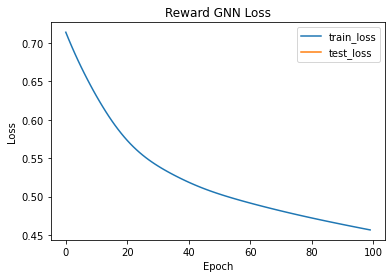

In [461]:
y_train = train_reward_loss.values()
x_train = train_reward_loss.keys()

y_loss = test_reward_loss.values()
x_loss = test_reward_loss.keys()
import matplotlib.pyplot as plt

plt.plot(x_train, y_train, label = "train_loss")
plt.plot(x_loss, y_loss, label = "test_loss")
plt.title('Reward GNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()